In [264]:
# System management 
import os
import time
import pickle
import dill
from collections import Counter

# Data manipulation
import numpy as np
import pandas as pd
import re
pd.options.display.max_rows = 400

# Scikit-learn
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, auc, classification_report
from sklearn.preprocessing import StandardScaler 
from sklearn.feature_selection import RFECV

# Predictive Models
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import lightgbm 
from xgboost import XGBClassifier

# Hyperparameters optimisation
from hyperopt import tpe, hp, fmin, space_eval, STATUS_OK, Trials, SparkTrials
from hyperopt.pyll.base import scope

# Balancing data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

# Interpratability
from lime import lime_tabular
import shap

# MLFlow tracking
import mlflow
from mlflow import log_metric, log_param, log_artifacts

# Data drift
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
#import seaborn as sns
plt.style.use('fivethirtyeight')
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':25,
     'ytick.labelsize':25,
     'axes.labelsize': 25,
     'legend.fontsize': 25,
     'axes.titlesize':45,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })
%matplotlib inline
sns.set_theme(palette='Set1')

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [265]:
# Set main directory
project_path = '/Users/felipelima/alternance/projets/credit-scoring/'
os.chdir(project_path)

In [266]:
# Load data
data = pd.read_csv('data/processed/train_feature_engineering.csv').drop(columns=['SK_ID_CURR'])
#data_test = pd.read_csv('data/processed/test_feature_engineering.csv').drop(columns=['SK_ID_CURR'])

#### MLFlow 

Set MLFlow tracking

In [267]:
# Create experiment
experiment_name = 'credit_scoring'
# Check if the experiment exists
experiment = mlflow.get_experiment_by_name(experiment_name)
# If the experiment doesn't exist, create it
if experiment is None: 
    mlflow.create_experiment(experiment_name)
# Set the experiment 
mlflow.set_experiment(experiment_name)
mlflow.end_run()

In [268]:
# Function to log model to mlflow
def log_mlflow(model, name, params, business_score, roc_auc=None, f1_score=None, accuracy=None, 
               precision=None, recall=None, specificity=None, fpr=None, fitting_time=None):

    # Track params and metrics 
    with mlflow.start_run():
        # Set run name
        mlflow.set_tag('mlflow.runName', name)

        # Set parameters
        for param, value in params.items():
            mlflow.log_param(param, value)

        # Set metrics
        mlflow.log_metric('Business score', business_score)
        mlflow.log_metric('AUC', roc_auc)
        mlflow.log_metric('F1', f1_score)
        mlflow.log_metric('Accuracy', accuracy)
        mlflow.log_metric('Precision', precision)
        mlflow.log_metric('Recall', recall)
        mlflow.log_metric('Specificity', specificity)
        mlflow.log_metric('False positive rate', fpr)
        if fitting_time is not None: 
            mlflow.log_metric('Fitting time', fitting_time)

        # Save model to artifacts
        mlflow.sklearn.log_model(model, name)

    mlflow.end_run()

#### Data pre-processing

In [269]:
# Define target and features
TARGET = 'TARGET'
target = data[TARGET]
features = data.drop(columns=TARGET)
features_names = data.drop(columns=TARGET).columns.to_list()

# Define training set size
TRAIN_SIZE = 0.8

# Define random state
RANDOM_STATE = 42

##### Missing values

Fill the missing values with a simple imputer

In [270]:
# Check missing values
nan_values = data.isna().sum().sum()
print('Missing values = {} ({:.2%})'.format(nan_values, nan_values/data.size))

Missing values = 32442173 (18.35%)


In [271]:
# Create imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')

# Fit to data
imp_mean.fit(features)

# Transform data
features_fill = imp_mean.transform(features)
features_fill = pd.DataFrame(features_fill, columns=features_names)

In [272]:
nan_values = features_fill.isna().sum().sum()
print('Missing values = {} ({:.2%})'.format(nan_values, nan_values/data.size))

Missing values = 0 (0.00%)


#### Split data

In [273]:
# Split dataset (filled)
x_train, x_test, y_train, y_test = train_test_split(features_fill, target, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(246004, 574) (246004,)
(61502, 574) (61502,)


#### Data distribution

In [274]:
y_train_counter = Counter(y_train)
y_test_counter = Counter(y_test)
print('Training target statistics:', y_train_counter)
print('Testing target statistics:', y_test_counter)

# Print ratio
print('Ratio is 1:{:.0f} in training/validation set'.format(y_train_counter[0] / y_train_counter[1]))
print('Ratio is 1:{:.0f} in test set'.format(y_test_counter[0] / y_test_counter[1]))

Training target statistics: Counter({0.0: 226154, 1.0: 19850})
Testing target statistics: Counter({0.0: 56527, 1.0: 4975})
Ratio is 1:11 in training/validation set
Ratio is 1:11 in test set


In [275]:
# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.5) # oversample to 1:2 ratio 
under = RandomUnderSampler(sampling_strategy=1) # undersample to 1:1 ratio

# Define pipeline
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
x_res, y_res = pipeline.fit_resample(x_train, y_train)

print('Training target statistics:', Counter(y_res))
print('Ratio is 1:{:.0f} in training/validation set'.format(Counter(y_res)[0] / Counter(y_res)[1]))
print('Validation target statistics:', Counter(y_test))
print('Ratio is 1:{:.0f} in test set'.format(Counter(y_test)[0] / Counter(y_test)[1]))

Training target statistics: Counter({0.0: 113077, 1.0: 113077})
Ratio is 1:1 in training/validation set
Validation target statistics: Counter({0.0: 56527, 1.0: 4975})
Ratio is 1:11 in test set


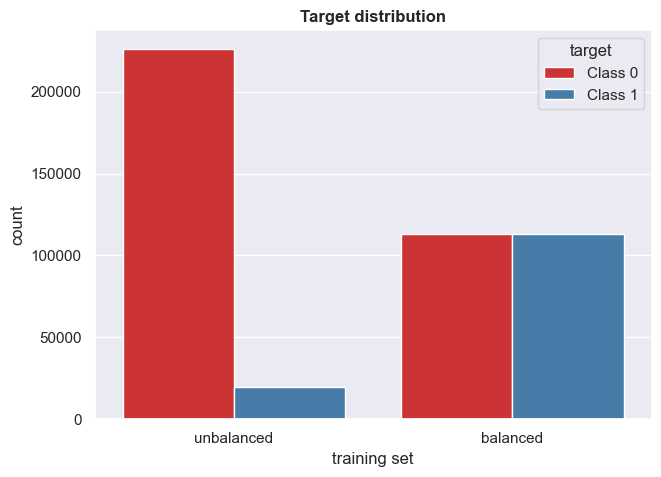

In [276]:
# Display barplot of distribution
class_distr_df = pd.DataFrame({'training set': ['unbalanced', 'unbalanced', 'balanced', 'balanced'],
                               'target': ['Class 0', 'Class 1', 'Class 0', 'Class 1'],
                               'count': [y_train_counter[0], y_train_counter[1], Counter(y_res)[0], Counter(y_res)[1]]})

# Display barplot
sns.barplot(class_distr_df, x='training set', y='count', hue='target')
plt.title('Target distribution')
plt.show()

The resulting data is now balanced. However, since we will test using cross validation, the resampling step shall be done for each cross validation iteration.

#### Metric functions

In [277]:
# 1 --> dont repay
# 0 --> repay
# Custom loss function based on business rule =  
# cost FN (dont repay - predicted as repay) = 10 cost FP (repay - predicted as dont repay)
def business_loss_func(y_true, y_pred): # 0 --> best # 1 --> worst
    #beta=10
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    #precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    #recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    #score = ((1 + beta**2) * precision * recall) / ((beta**2 * precision) + recall) if (precision + recall) > 0 else 0

    #cost = (fn + 10 * fp) / (len(y_true))
    #score = 1 - cost

    tn_rate, tp_rate, fp_rate, fn_rate = 1, 1, -1, -10

    total_default = tp + fn
    total_not_default = tn + fp

    total_gain = tn*tn_rate + tp*tp_rate + fp*fp_rate + fn*fn_rate
    min_gain = total_not_default*tn_rate + total_default*fn_rate
    max_gain = total_not_default*tn_rate + total_default*tp_rate

    score = (total_gain - min_gain) / (max_gain - min_gain)

    return score

"""def business_scorer(y_true, y_pred): 
    return business_loss_func(y_true, y_pred)"""

business_scorer = make_scorer(business_loss_func, greater_is_better=True)

def specificity_score_func(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity
specificity_scorer = make_scorer(specificity_score_func, greater_is_better=True)

def false_positive_rate_score_func(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)
    return fpr
fpr_scorer = make_scorer(false_positive_rate_score_func, greater_is_better=False)

#### Classification

In [278]:
def plot_cf_matrix_roc_curve(y_true, y_pred, y_pred_proba, feature_importance=None):
    fig = plt.figure(figsize=(20,15))
    # Left subplot - Confusion Matrix
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    # Right subplot - ROC curve
    plt.subplot(222)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

In [279]:
def train_model_with_cross_val(model, X = x_train, y = y_train, cv=5, param_grid = None, fast_train = None):
    # Remove special caracters from column name --> lightgbm
    if isinstance(model, LGBMClassifier): 
        X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    # Get only 20% of data for faster train / hyperparameter optmization
    if fast_train is not None: 
        X, _, y, _ = train_test_split(X, y, train_size=fast_train, random_state=RANDOM_STATE)

    # Calculate various evaluation metrics
    results_cv = {}
    results_test = {}

    # Define your scoring metrics
    scoring = {
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'roc_auc': 'roc_auc',
            'specificity': specificity_scorer,
            'fpr': fpr_scorer,
            'business': business_scorer
    }

    # Split data into training and validation sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

    # Set pipeline with oversampling and undersampling
    pipeline = Pipeline([
                ('over', SMOTE(sampling_strategy=0.5, random_state=RANDOM_STATE)), 
                ('under', RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)), 
                ('classifier', model)
    ])

    # Create a cross-validation generator
    strat_kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    # ça sert vraiment ?

    if param_grid is not None:
        # Perform hyperparameter tuning using GridSearchCV /  RandomizedSearchCV
        t0 = time.time()
        randomized_search = RandomizedSearchCV(pipeline, param_grid, cv=strat_kf, scoring=scoring, n_jobs=-1, random_state=RANDOM_STATE, refit='business')
        randomized_search.fit(x_train, y_train)
        best_model = randomized_search.best_estimator_
        best_index = randomized_search.cv_results_['params'].index(randomized_search.best_params_)

        for score in scoring.keys():
            results_cv[score] = randomized_search.cv_results_['mean_test_' + score][best_index]
        results_cv['randomized_search_time'] = time.time() - t0

    else:
        # Perform cross-validation with the best model (with or without hyperparameter opt)
        t0 = time.time() 
        best_model = pipeline
        scores = cross_validate(best_model, x_train, y_train, cv=strat_kf, scoring=scoring, n_jobs=-1)

        for score in scoring.keys():
            results_cv[score] = scores[f'test_{score}'].mean()
        results_cv['execution_time'] = time.time() - t0

        # Fit / train with training set
        t0 = time.time()
        best_model.fit(x_train, y_train)
        results_test['fitting_time'] = time.time() - t0

    # Predict on the test set
    y_pred = best_model.predict(x_test)
    y_pred_proba = best_model.predict_proba(x_test)[:, 1]

    # Calculate validation metrics 
    results_test['accuracy'] = accuracy_score(y_test, y_pred)
    results_test['precision'] = precision_score(y_test, y_pred)
    results_test['recall'] = recall_score(y_test, y_pred)
    results_test['f1'] = f1_score(y_test, y_pred)
    results_test['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
    results_test['specificity'] = specificity_score_func(y_test, y_pred)
    results_test['fpr'] = false_positive_rate_score_func(y_test, y_pred)
    results_test['business'] = business_loss_func(y_test, y_pred)
    
    plot_cf_matrix_roc_curve(y_test, y_pred, y_pred_proba)

    return best_model, results_cv, results_test

In [280]:
def plot_metrics(results_cv, results_test, metrics): 
    # Create a 2x3 grid of subplots
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Model Metrics Comparison', fontsize=16)

    # Pastel colors
    pastel_colors = ['#FF6666', '#FFCC99', '#99FF99', '#66B2FF', '#C2C2F0', '#999966', '#FF69B4', '#B19CD9']

    # Models to remove x-axis and y-axis labels
    no_x_labels = []#['DummyClassifier', 'LogisticRegression', 'RandomForest']
    no_y_labels = []#['LogisticRegression', 'RandomForest', 'LightGBM', 'CatBoost']

    # Iterate over models and plot metrics
    for i, model in enumerate(results_cv.keys()):
        metrics_dict = results_cv[model]
        test_metrics_dict = results_test[model]
        ax = axs[i // 3, i % 3]

        x = np.arange(len(metrics))
        width = 0.4

        # Train bars
        train_metrics = [metrics_dict[metric] for metric in metrics]
        ax.bar(x - width/2, train_metrics, width, label='Train', color=pastel_colors, alpha=0.7)

        # Test bars
        test_metrics = [test_metrics_dict[metric] for metric in metrics]
        ax.bar(x + width/2, test_metrics, width, label='Test', color='gray', alpha=0.7)

        ax.set_title(model)
        ax.set_xticks(x)
        ax.set_xticklabels(metrics, rotation=45)
        ax.set_ylim(0, 1)

        if model in no_x_labels:
            ax.set_xticklabels([])

        if model in no_y_labels:
            ax.set_yticklabels([])

    # Adjust subplot layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    # Add a legend
    axs[1, 2].legend(loc='upper right')

    # Show the plots
    plt.show()

#### Modelling

For the sake of computation, we will use 20% of the data

##### DummyClassifier (= baseline 0)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 6.2 µs


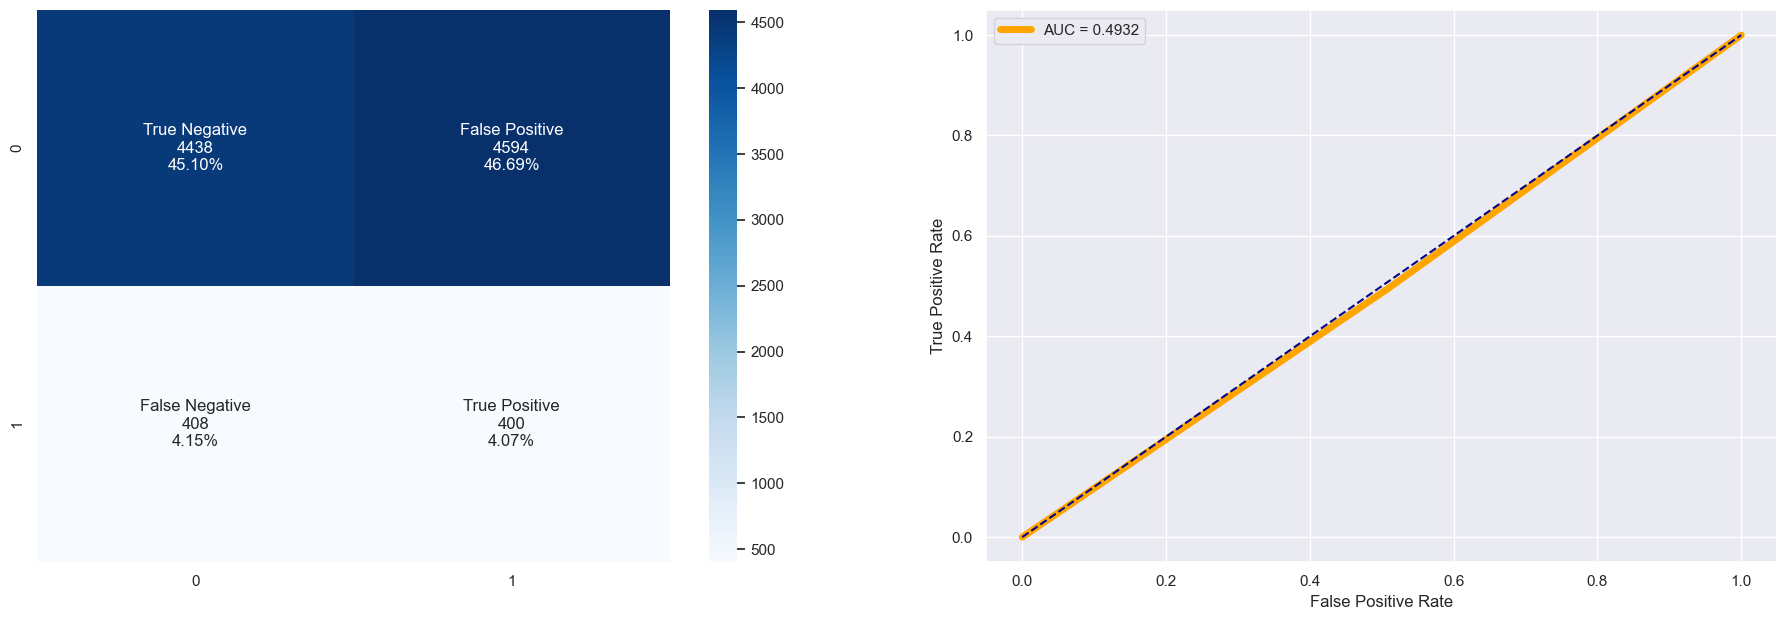

In [281]:
%time
# Create logistic regression model
dc = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dc_name = 'DummyClassifier'

# Compute results 
dc_model, dc_results_cv, dc_results_test = train_model_with_cross_val(dc, cv=5, fast_train=0.2)

# Save logs
log_mlflow(dc_model, dc_name, params=dc_model.named_steps['classifier'].get_params(), business_score=dc_results_test['business'], 
           roc_auc=dc_results_test['roc_auc'], f1_score=dc_results_test['f1'], accuracy=dc_results_test['accuracy'],
           precision=dc_results_test['precision'], recall=dc_results_test['recall'], specificity=dc_results_test['specificity'],
           fpr=dc_results_test['fpr'], fitting_time=dc_results_test['fitting_time'])

##### Logistical regression (= baseline 1)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.86 µs


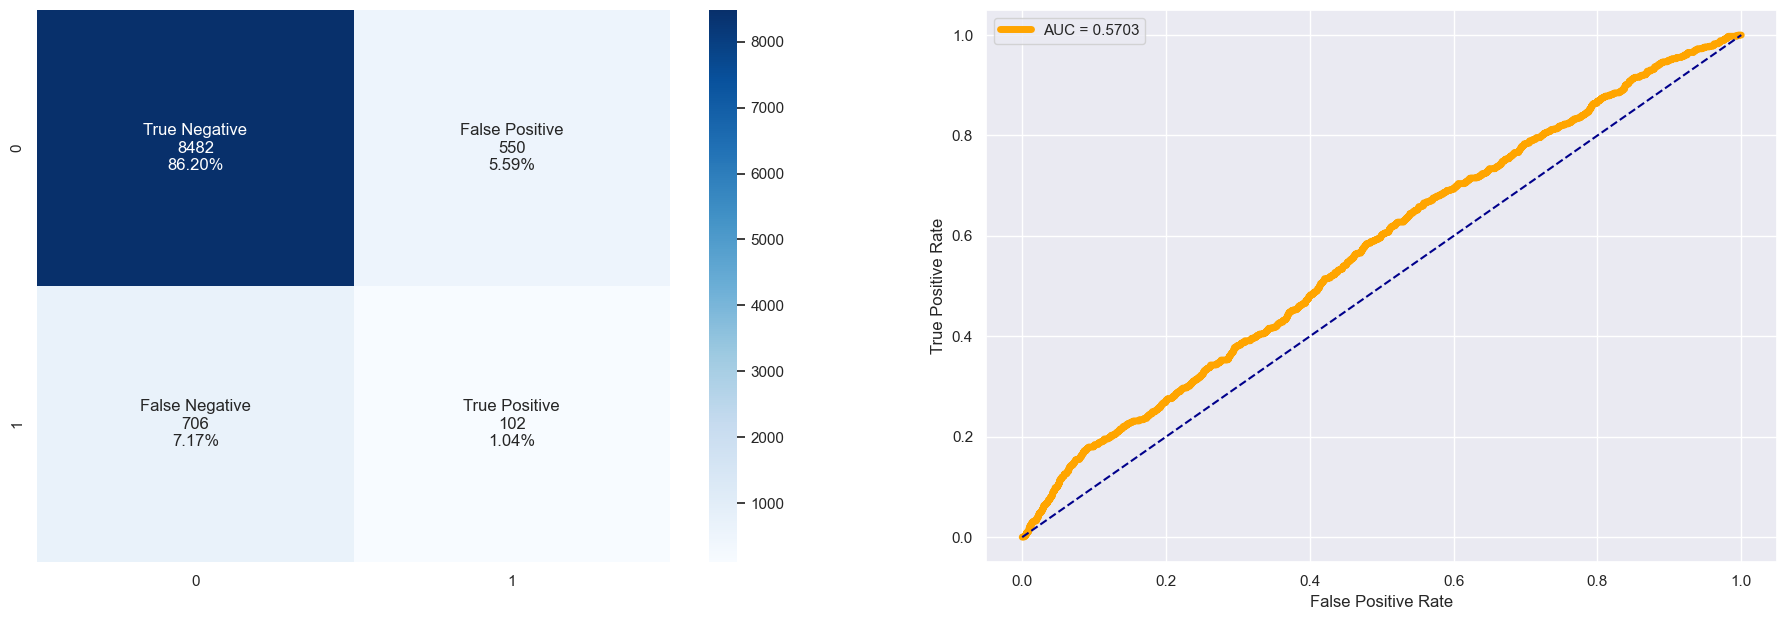

In [282]:
%time
# Create logistic regression model
lr = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1)
lr_name = 'LogisticRegression'

# Compute results 
lr_model, lr_results_cv, lr_results_test = train_model_with_cross_val(lr, cv=5, fast_train=0.2)

# Save logs
log_mlflow(lr_model, lr_name, params=lr_model.named_steps['classifier'].get_params(), business_score=lr_results_test['business'], 
           roc_auc=lr_results_test['roc_auc'], f1_score=lr_results_test['f1'], accuracy=lr_results_test['accuracy'],
           precision=lr_results_test['precision'], recall=lr_results_test['recall'], specificity=lr_results_test['specificity'],
           fpr=lr_results_test['fpr'], fitting_time=lr_results_test['fitting_time'])

##### RandomForest

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


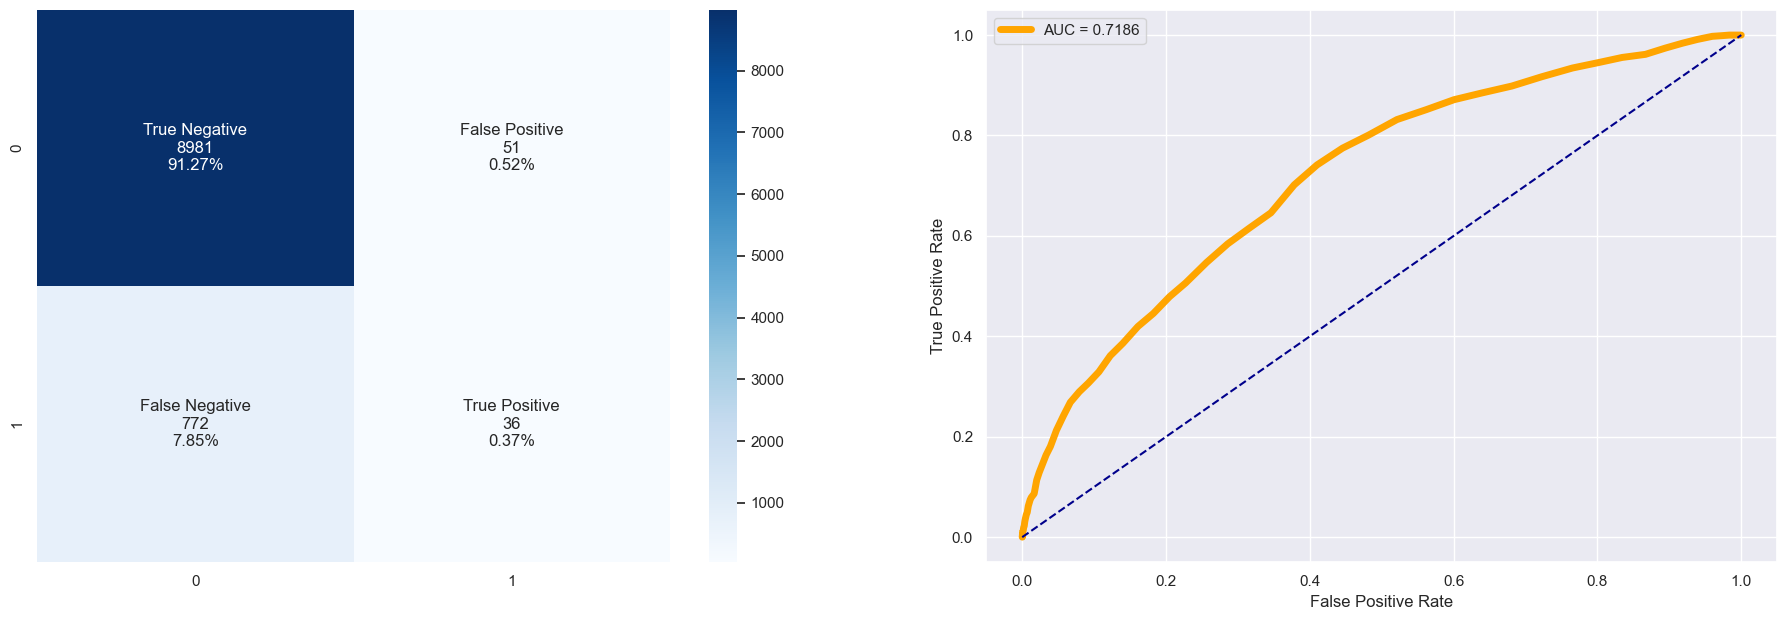

In [283]:
%time
# Create random forest classifier
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rf_name = 'RandomForest'

# Compute results 
rf_model, rf_results_cv, rf_results_test = train_model_with_cross_val(rf, cv=5, fast_train=0.2)

# Save logs
log_mlflow(rf_model, rf_name, params=rf_model.get_params(), business_score=rf_results_test['business'], 
           roc_auc=rf_results_test['roc_auc'], f1_score=rf_results_test['f1'], accuracy=rf_results_test['accuracy'],
           precision=rf_results_test['precision'], recall=rf_results_test['recall'], specificity=rf_results_test['specificity'],
           fpr=rf_results_test['fpr'], fitting_time=rf_results_test['fitting_time'])

##### XGBoost

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 11.9 µs


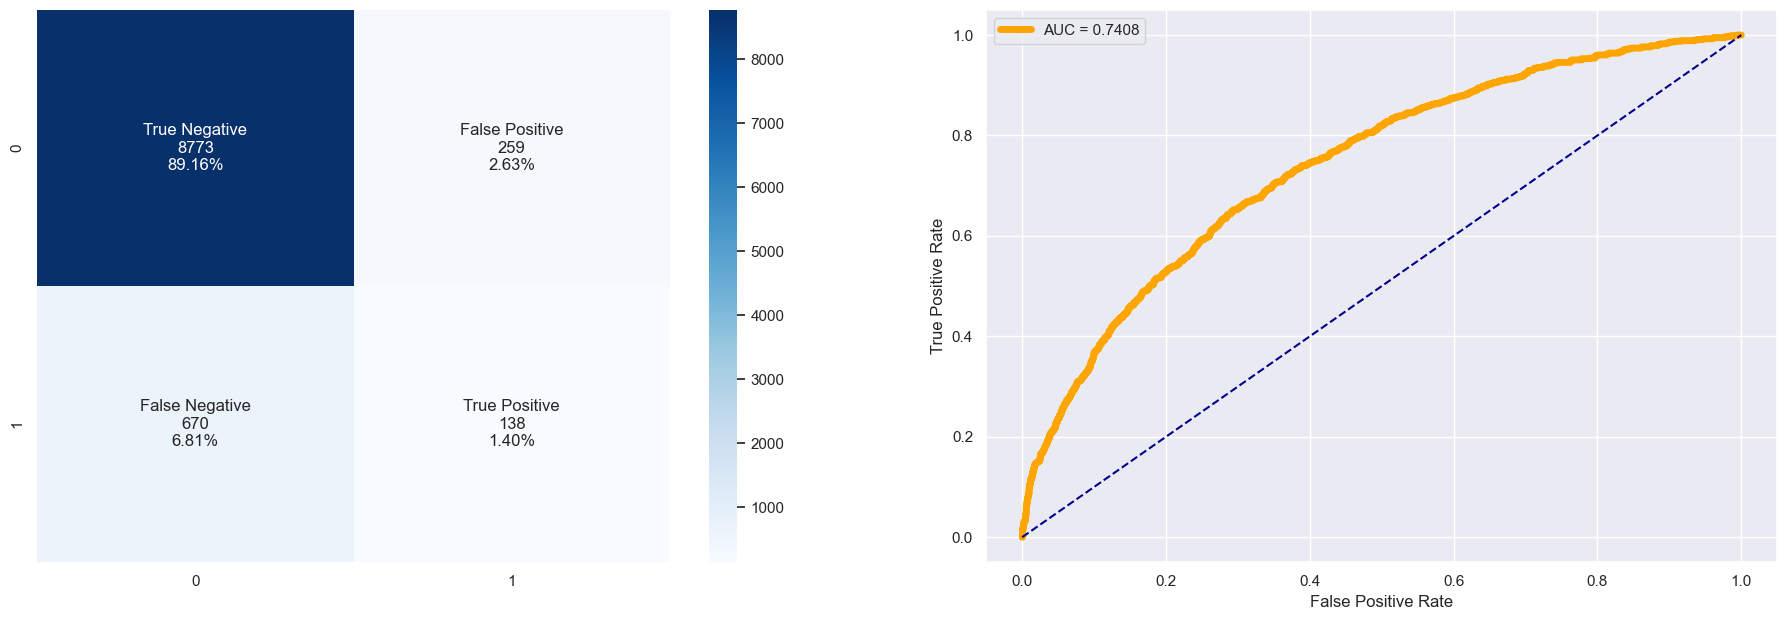

In [284]:
%time
# Create XGBoost classifier
xgbc = XGBClassifier(random_state=RANDOM_STATE, tree_method='auto', predictor='cpu_predictor')
xgbc_name = 'XGBoost'

# Compute results 
xgbc_model, xgbc_results_cv, xgbc_results_test = train_model_with_cross_val(xgbc, cv=5, fast_train=0.2)

# Save logs
log_mlflow(xgbc_model, xgbc_name, params=xgbc_model.named_steps['classifier'].get_params(), business_score=xgbc_results_test['business'], 
           roc_auc=xgbc_results_test['roc_auc'], f1_score=xgbc_results_test['f1'], accuracy=xgbc_results_test['accuracy'],
           precision=xgbc_results_test['precision'], recall=xgbc_results_test['recall'], specificity=xgbc_results_test['specificity'],
           fpr=xgbc_results_test['fpr'], fitting_time=xgbc_results_test['fitting_time'])

##### LightGBM

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 7.87 µs
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 98733
[LightGBM] [Info] Number of data points in the train set: 28936, number of used features: 493
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98664
[LightGBM] [Info]

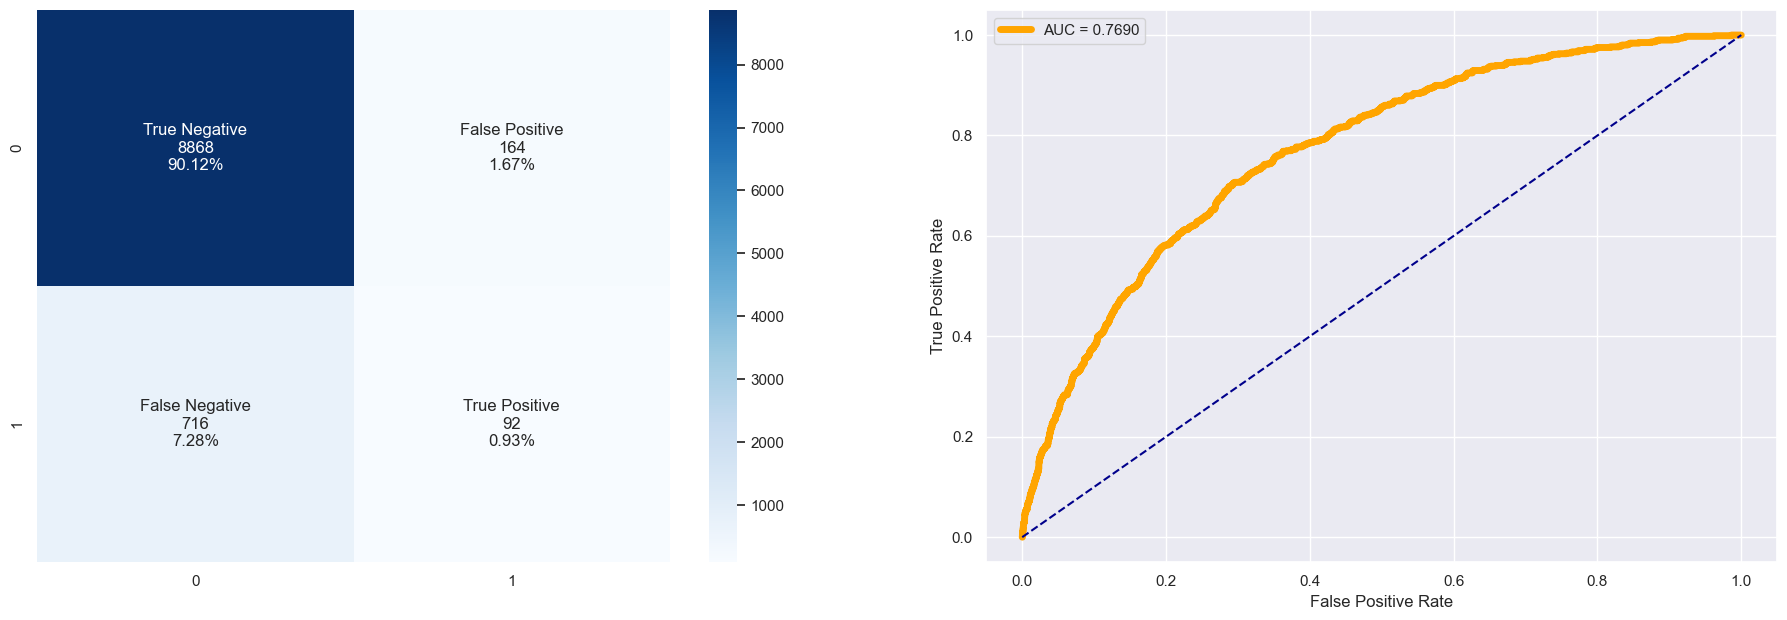

In [285]:
%time
# Create LightGBM classifier
lgbmc = LGBMClassifier(random_state=RANDOM_STATE, device='cpu', n_jobs=-1)
lgbmc_name = 'LightGBM'

# Compute results 
lgbmc_model, lgbmc_results_cv, lgbmc_results_test = train_model_with_cross_val(lgbmc, cv=5, fast_train=0.2)

# Save logs
log_mlflow(lgbmc_model, lgbmc_name, params=lgbmc_model.named_steps['classifier'].get_params(), business_score=lgbmc_results_test['business'], 
           roc_auc=lgbmc_results_test['roc_auc'], f1_score=lgbmc_results_test['f1'], accuracy=lgbmc_results_test['accuracy'],
           precision=lgbmc_results_test['precision'], recall=lgbmc_results_test['recall'], specificity=lgbmc_results_test['specificity'],
           fpr=lgbmc_results_test['fpr'], fitting_time=lgbmc_results_test['fitting_time'])


##### CatBoost

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 8.34 µs


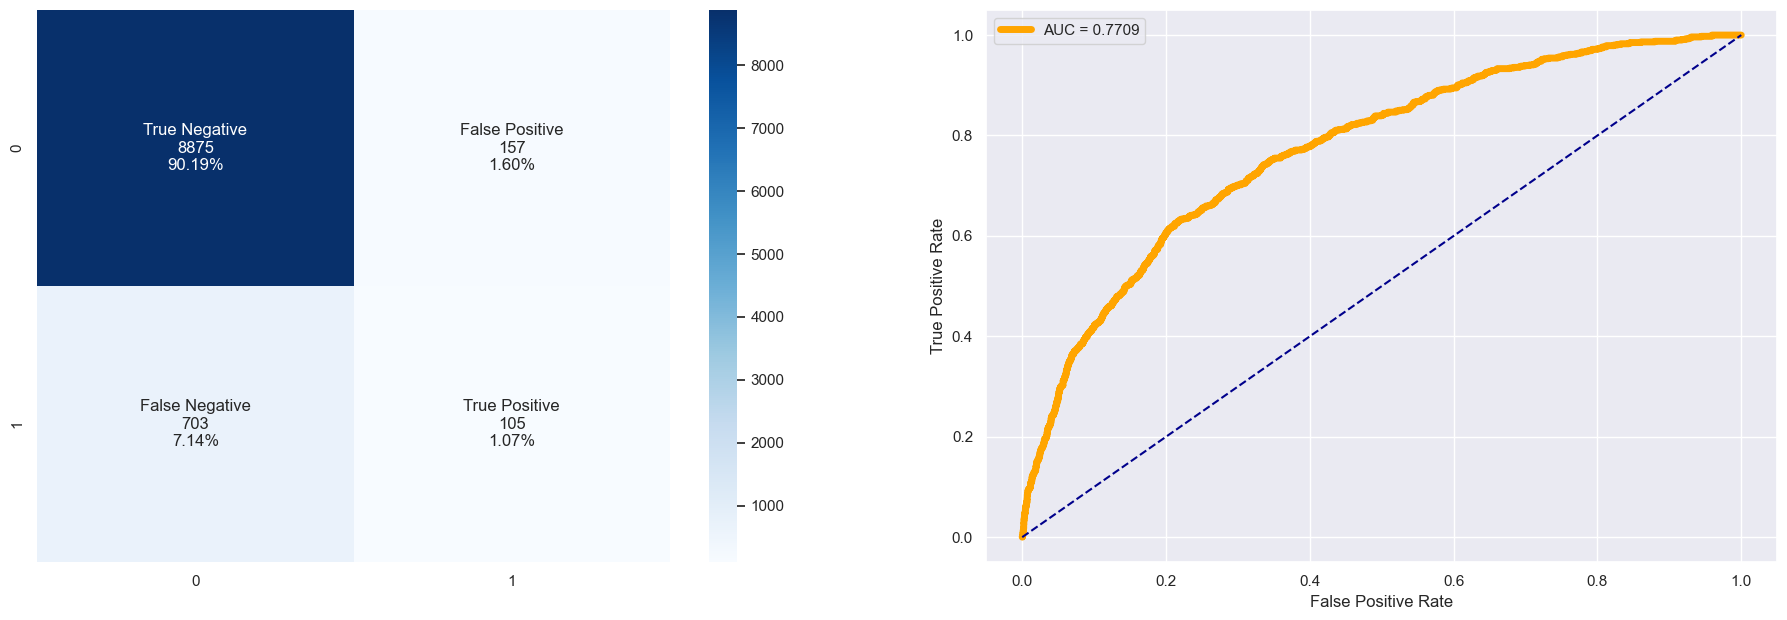

In [286]:
%time
# Create CatBoost classifier
cbc = CatBoostClassifier(random_state=RANDOM_STATE, task_type='CPU', logging_level='Silent')
cbc_name = 'CatBoost'

# Compute results 
cbc_model, cbc_results_cv, cbc_results_test = train_model_with_cross_val(cbc, cv=5, fast_train=0.2)

# Save logs
log_mlflow(cbc_model, cbc_name, params=cbc_model.named_steps['classifier'].get_params(), business_score=cbc_results_test['business'], 
           roc_auc=cbc_results_test['roc_auc'], f1_score=cbc_results_test['f1'], accuracy=cbc_results_test['accuracy'],
           precision=cbc_results_test['precision'], recall=cbc_results_test['recall'], specificity=cbc_results_test['specificity'],
           fpr=cbc_results_test['fpr'], fitting_time=cbc_results_test['fitting_time'])

##### Comparison

In [287]:
results_cv = {
    'DummyClassifier': dc_results_cv,
    'LogisticRegression': lr_results_cv, 
    'RandomForest': rf_results_cv,
    'XGBoost': xgbc_results_cv,
    'LightGBM': lgbmc_results_cv,
    'CatBoost': cbc_results_cv
}

pd.DataFrame.from_dict(results_cv)

,DummyClassifier,LogisticRegression,RandomForest,XGBoost,LightGBM,CatBoost
accuracy,0.497282,0.873196,0.916235,0.903023,0.911255,0.912043
precision,0.082885,0.146510,0.320625,0.312412,0.359231,0.368857
recall,0.516928,0.117241,0.030094,0.163636,0.119122,0.120690
f1,0.142863,0.130137,0.055013,0.214628,0.178349,0.181562
roc_auc,0.506238,0.566691,0.713448,0.728040,0.753398,0.753735
specificity,0.495549,0.939867,0.994388,0.968233,0.981117,0.981836
fpr,-0.504451,-0.060133,-0.005612,-0.031767,-0.018883,-0.018164
business,-0.523027,-0.006726,0.018524,0.098148,0.080194,0.083243
execution_time,2.871458,4.255163,15.112915,104.593110,10.224179,135.665009


In [288]:
results_test = {
    'DummyClassifier': dc_results_test,
    'LogisticRegression': lr_results_test, 
    'RandomForest': rf_results_test,
    'XGBoost': xgbc_results_test,
    'LightGBM': lgbmc_results_test,
    'CatBoost': cbc_results_test
}

pd.DataFrame.from_dict(results_test)

,DummyClassifier,LogisticRegression,RandomForest,XGBoost,LightGBM,CatBoost
fitting_time,0.711038,3.168958,4.185854,24.580996,3.318901,33.483451
accuracy,0.491667,0.872358,0.916362,0.905589,0.910569,0.912602
precision,0.080096,0.156442,0.413793,0.347607,0.359375,0.400763
recall,0.495050,0.126238,0.044554,0.170792,0.113861,0.129950
f1,0.137883,0.139726,0.080447,0.229046,0.172932,0.196262
roc_auc,0.493207,0.570308,0.718621,0.740782,0.768989,0.770916
specificity,0.491364,0.939105,0.994353,0.971324,0.981842,0.982617
fpr,0.508636,0.060895,0.005647,0.028676,0.018158,0.017383
business,-0.538704,0.002475,0.033078,0.112511,0.076958,0.094622


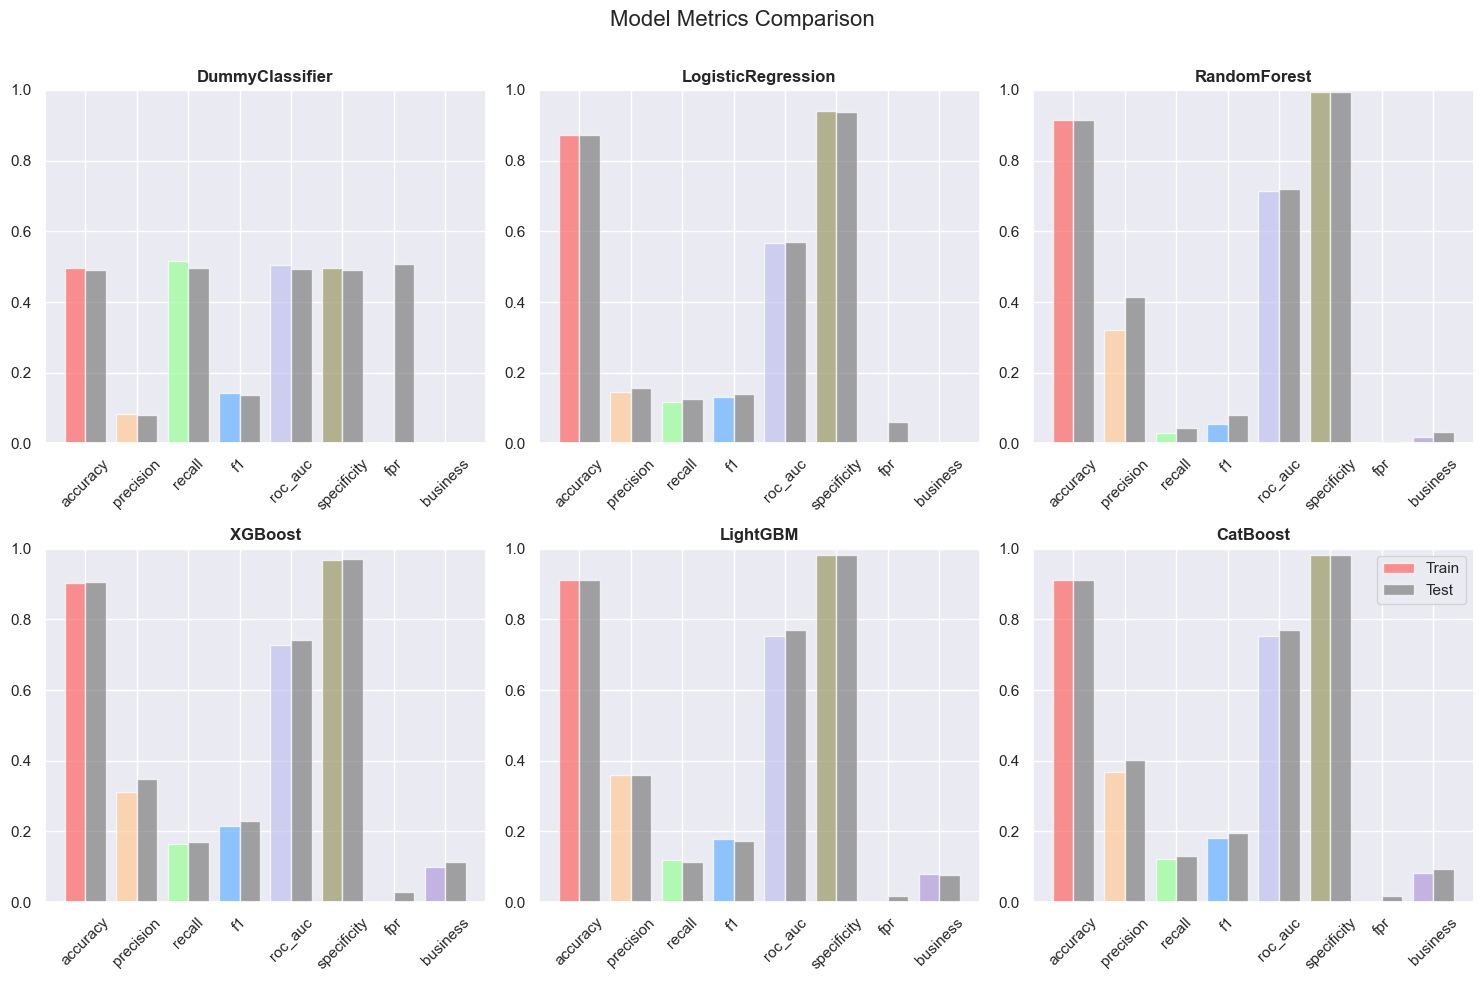

In [289]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'specificity', 'fpr', 'business']
plot_metrics(results_cv, results_test, metrics)

#### Hyperparameter optimization

For hyperparameter optimization, let's change few things for the sake of computation capacity: 
- Use 20% of total data

##### DummyClassifier (= baseline 0)

Since this one is the baseline 0, it does not need to be optimized.

##### Logistical regression (= baseline 1)

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 7.15 µs


/Users/felipelima/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/felipelima/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/felipelima/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/felipelima/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/felipelima/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/felipelima/Lib

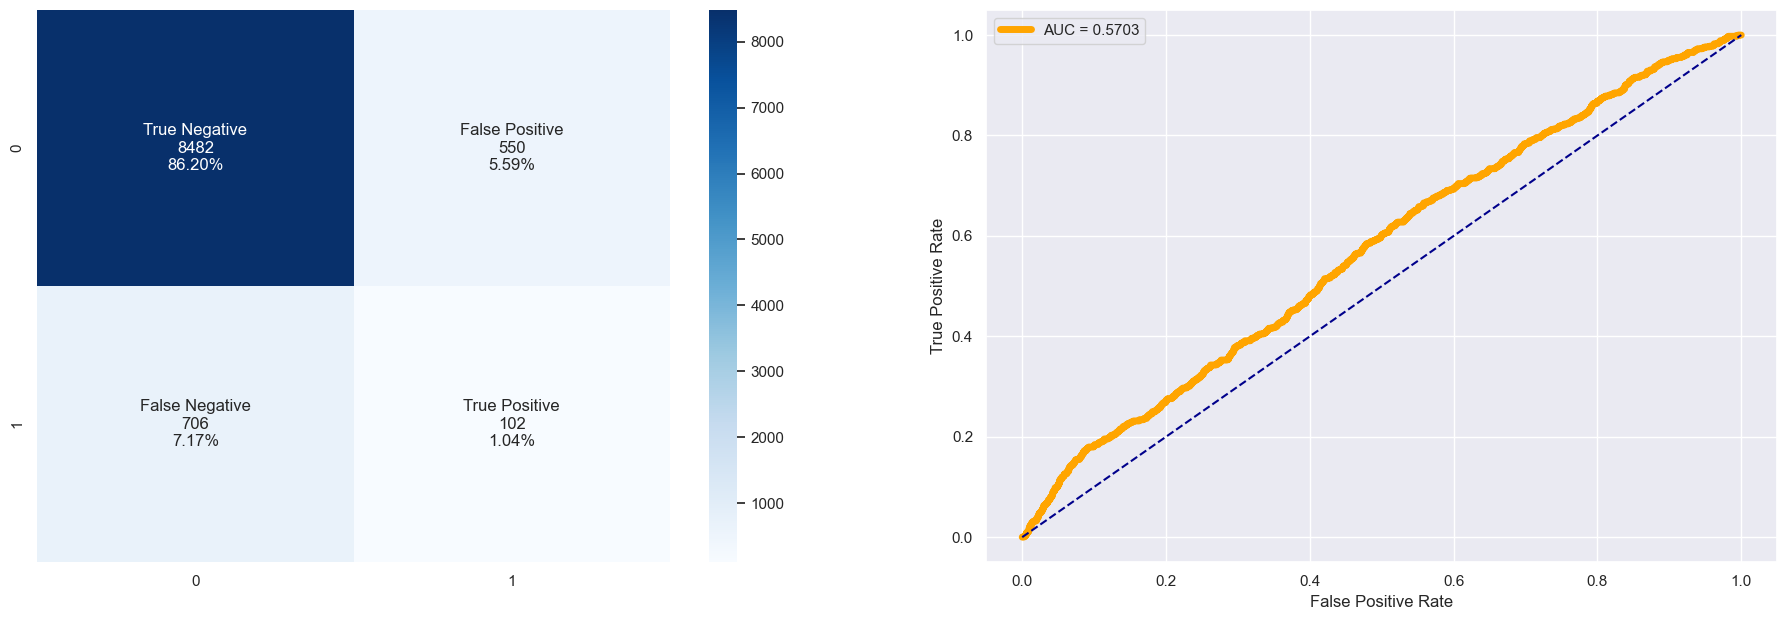

In [290]:
%time
# Create logistic regression model
lrt = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1)
lrt_name = 'LogisticRegression_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__C': [0.001, 0.01, 1, 10, 100],  # Regularization strength
    'classifier__penalty': ['l2', None],  # Regularization penalty --> only use l2 due to one-hot encode
    'classifier__solver': ['lbfgs', 'saga', 'newton-cholesky'],  # Solver options
    'classifier__max_iter': [100, 500, 1000],  # Maximum iterations
}

# Compute results and get fine-tuned model
lrt_model, lrt_results_cv, lrt_results_test = train_model_with_cross_val(lrt, param_grid=param_grid, cv=5, fast_train=0.2)

# Save logs
log_mlflow(lrt_model, lrt_name, params=lrt_model.named_steps['classifier'].get_params(), business_score=lrt_results_test['business'], 
           roc_auc=lrt_results_test['roc_auc'], f1_score=lrt_results_test['f1'], accuracy=lrt_results_test['accuracy'],
           precision=lrt_results_test['precision'], recall=lrt_results_test['recall'], specificity=lrt_results_test['specificity'],
           fpr=lrt_results_test['fpr'])

##### RandomForest

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 6.91 µs


/Users/felipelima/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/felipelima/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/felipelima/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or r

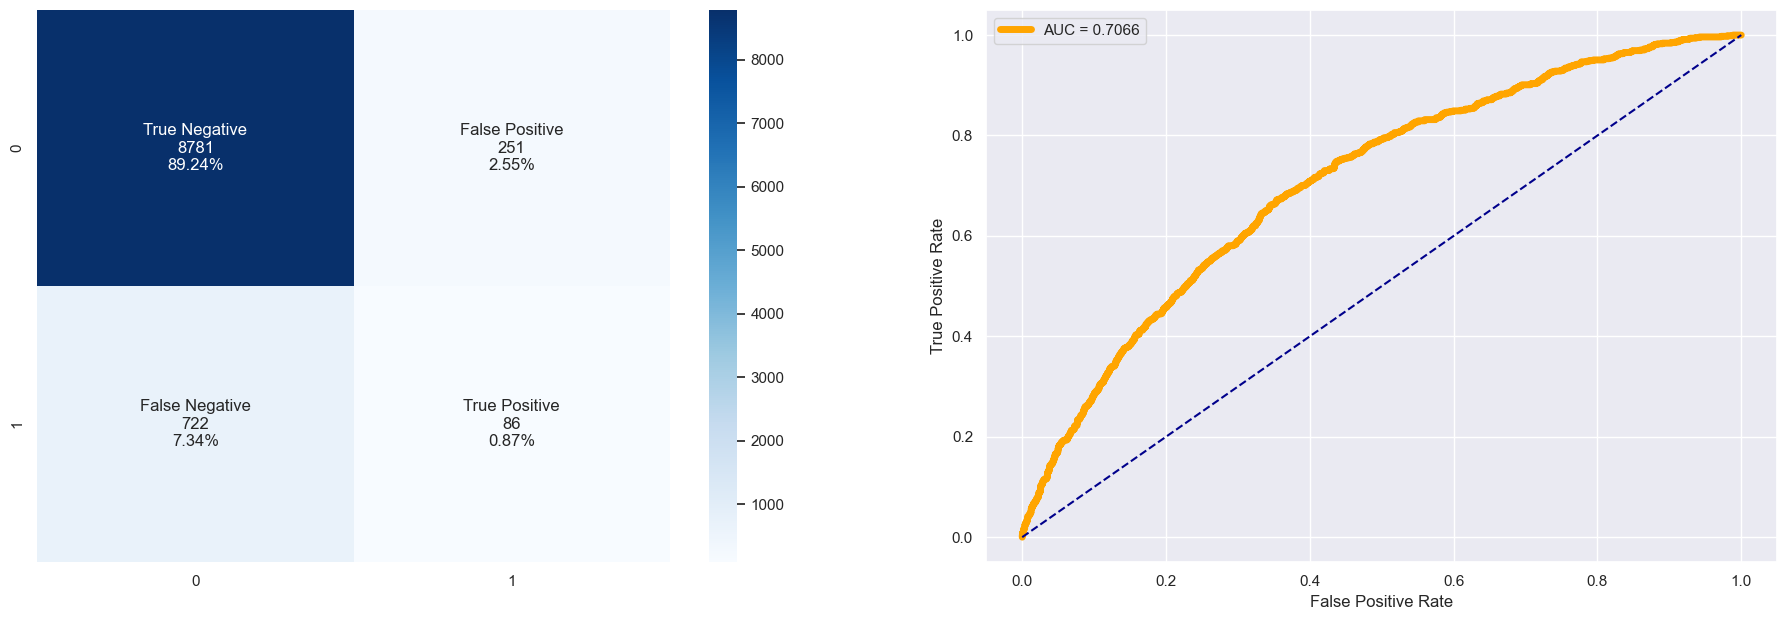

In [291]:
%time
# Create random forest classifier
rft = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rft_name = 'RandomForest_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__max_features': ['auto', 'sqrt'],
}

# Compute results and get fine-tuned model
rft_model, rft_results_cv, rft_results_test = train_model_with_cross_val(rft, param_grid=param_grid, cv=5, fast_train=0.2)

# Save logs
log_mlflow(rft_model, rft_name, params=rft_model.named_steps['classifier'].get_params(), business_score=rft_results_test['business'], 
           roc_auc=rft_results_test['roc_auc'], f1_score=rft_results_test['f1'], accuracy=rft_results_test['accuracy'],
           precision=rft_results_test['precision'], recall=rft_results_test['recall'], specificity=rft_results_test['specificity'],
           fpr=rft_results_test['fpr'])

##### XGBoost

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs


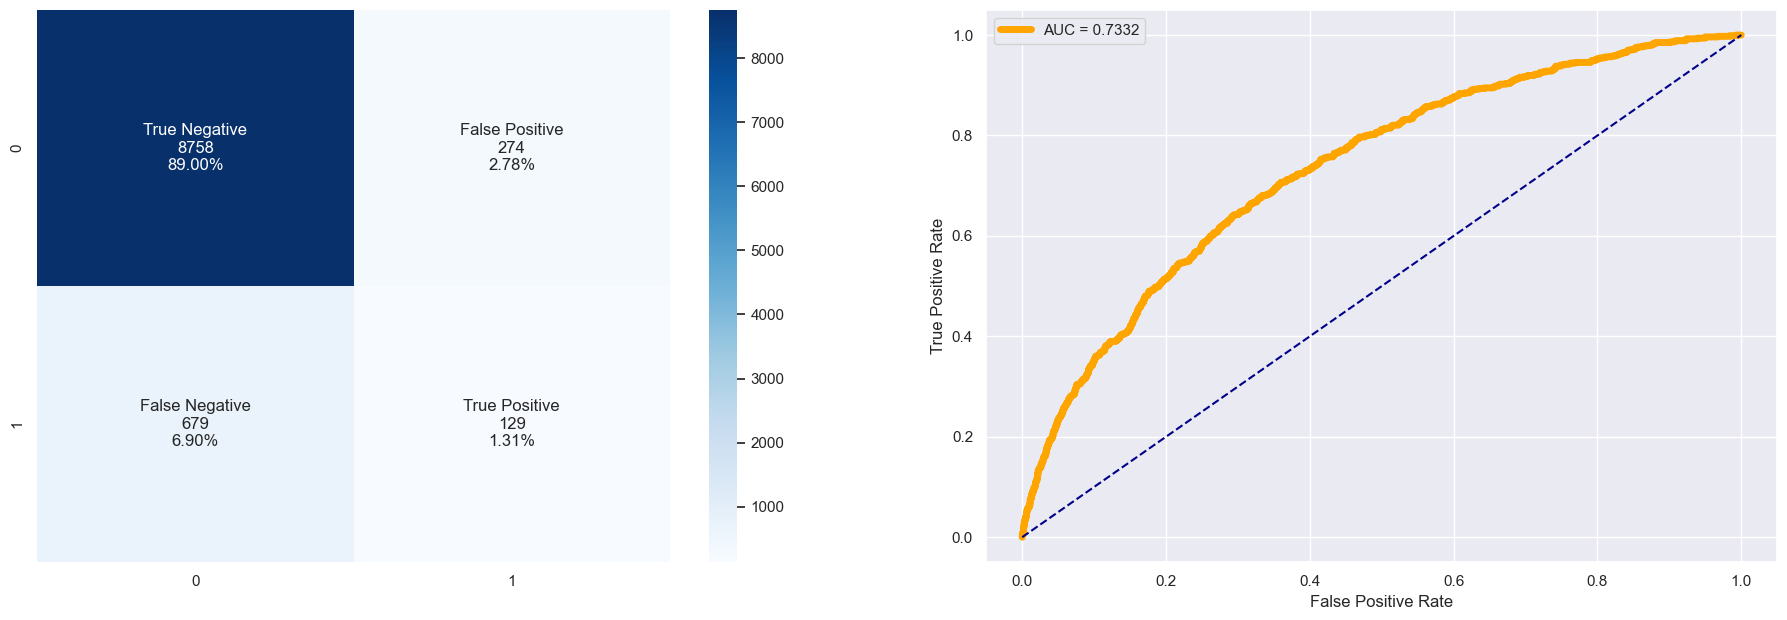

In [292]:
%time
# Create XGBoost classifier
xgbct = XGBClassifier(random_state=RANDOM_STATE, tree_method='auto', predictor='cpu_predictor')
xgbct_name = 'XGBoost_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.8, 0.9, 1.0]
}

# Compute results and get fine-tuned model
xgbct_model, xgbct_results_cv, xgbct_results_test = train_model_with_cross_val(xgbct, param_grid=param_grid, cv=5, fast_train=0.2)

# Save logs
log_mlflow(xgbct_model, xgbct_name, params=xgbct_model.named_steps['classifier'].get_params(), business_score=xgbct_results_test['business'], 
           roc_auc=xgbct_results_test['roc_auc'], f1_score=xgbct_results_test['f1'], accuracy=xgbct_results_test['accuracy'],
           precision=xgbct_results_test['precision'], recall=xgbct_results_test['recall'], specificity=xgbct_results_test['specificity'],
           fpr=xgbct_results_test['fpr'])



##### LightGBM

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 5.96 µs
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98741
[LightGBM] [Info] Number of data points in the train set: 28936, number of used features: 492
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.383019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98619
[LightGBM] [Info] Number of data points in the train set: 28936, number of used features: 489
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.

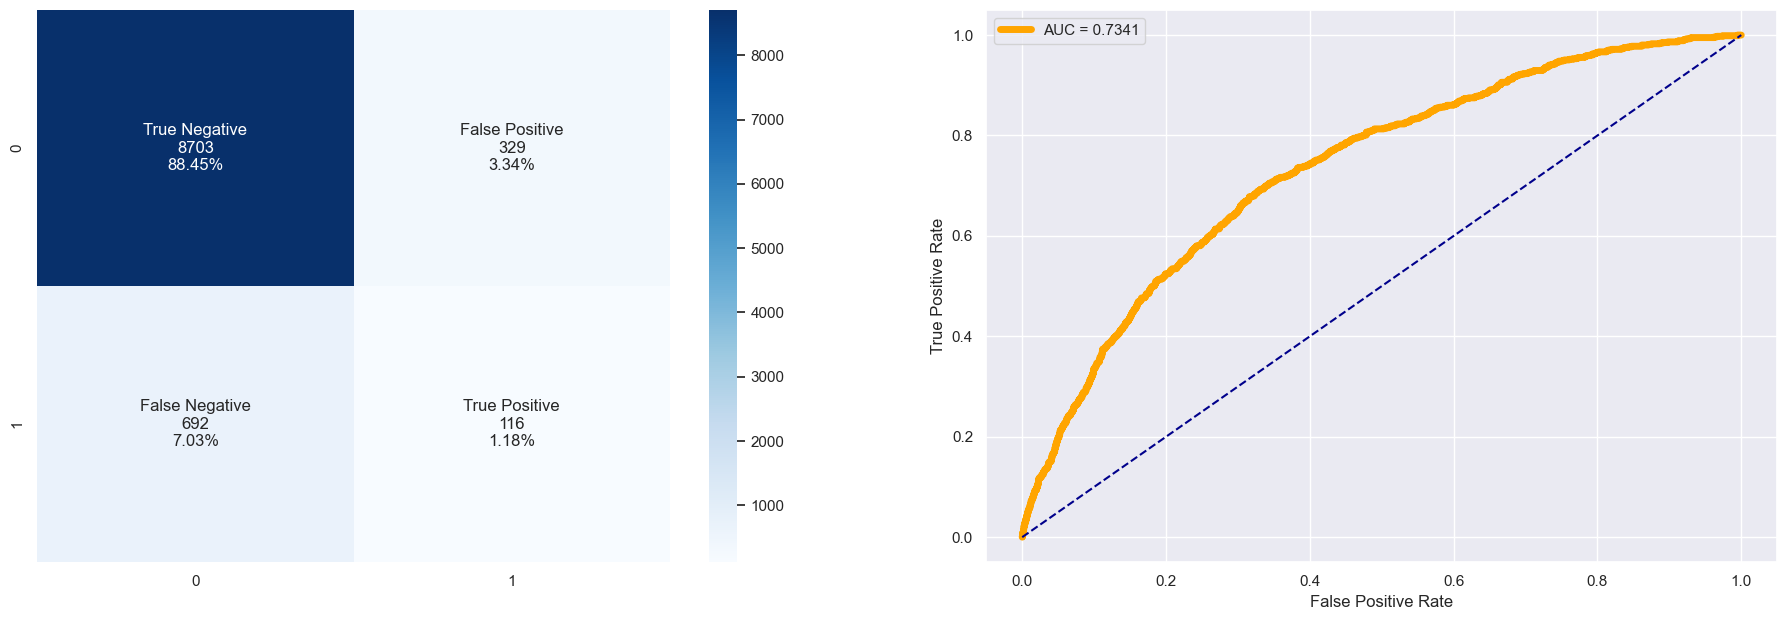

In [293]:
%time
# Create LightGBM classifier
lgbmct = LGBMClassifier(random_state=RANDOM_STATE, device='cpu', n_jobs=-1)
lgbmct_name = 'LightGBM_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.8, 0.9, 1.0]
}

# Compute results and get fine-tuned model
lgbmct_model, lgbmct_results_cv, lgbmct_results_test = train_model_with_cross_val(lgbmct, param_grid=param_grid, cv=5, fast_train=0.2)

# Save logs
log_mlflow(lgbmct_model, lgbmct_name, params=lgbmct_model.named_steps['classifier'].get_params(), business_score=lgbmct_results_test['business'], 
           roc_auc=lgbmct_results_test['roc_auc'], f1_score=lgbmct_results_test['f1'], accuracy=lgbmct_results_test['accuracy'],
           precision=lgbmct_results_test['precision'], recall=lgbmct_results_test['recall'], specificity=lgbmct_results_test['specificity'],
           fpr=lgbmct_results_test['fpr'])



##### CatBoost

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 6.2 µs


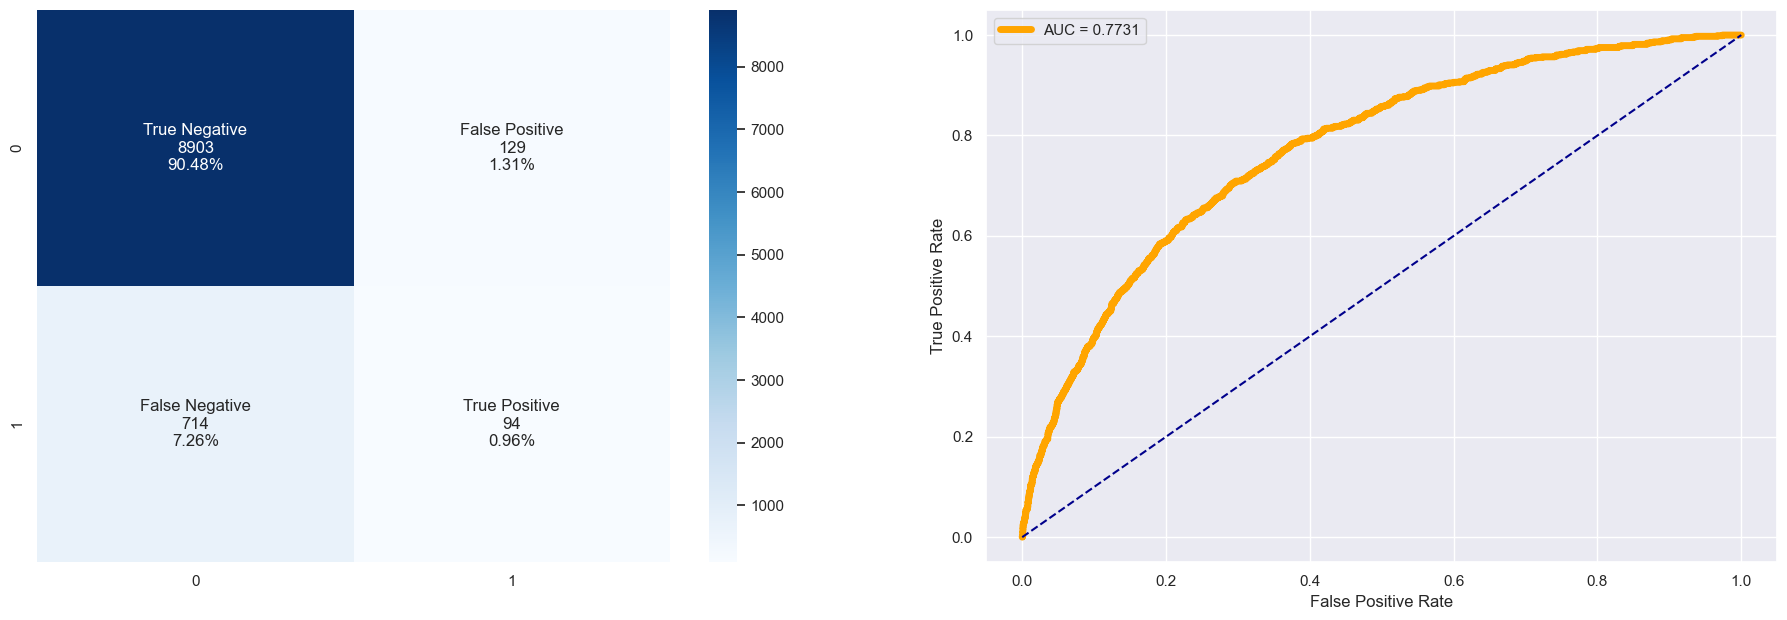

In [294]:
%time
# Create CatBoost classifier
cbct = CatBoostClassifier(random_state=RANDOM_STATE, task_type='CPU', logging_level='Silent')
cbct_name = 'CatBoost_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__iterations': [50, 100, 200],
    'classifier__depth': [6, 8, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.8, 0.9, 1.0],
}

# Compute results and get fine-tuned model
cbct_model, cbct_results_cv, cbct_results_test = train_model_with_cross_val(cbct, param_grid=param_grid, cv=5, fast_train=0.2)

# Save logs
log_mlflow(cbct_model, cbct_name, params=cbct_model.named_steps['classifier'].get_params(), business_score=cbct_results_test['business'], 
           roc_auc=cbct_results_test['roc_auc'], f1_score=cbct_results_test['f1'], accuracy=cbct_results_test['accuracy'],
           precision=cbct_results_test['precision'], recall=cbct_results_test['recall'], specificity=cbct_results_test['specificity'],
           fpr=cbct_results_test['fpr'])

##### Comparison

In [295]:
results_cv_tuned = {
    'DummyClassifier': dc_results_cv,
    'LogisticRegression': lrt_results_cv, 
    'RandomForest': rft_results_cv,
    'XGBoost': xgbct_results_cv,
    'LightGBM': lgbmct_results_cv,
    'CatBoost': cbct_results_cv
}

pd.DataFrame.from_dict(results_cv_tuned)

,DummyClassifier,LogisticRegression,RandomForest,XGBoost,LightGBM,CatBoost
accuracy,0.497282,0.873196,0.902287,0.901905,0.901702,0.913872
precision,0.082885,0.146510,0.253482,0.302312,0.299041,0.391467
recall,0.516928,0.117241,0.104702,0.160815,0.158621,0.112539
f1,0.142863,0.130137,0.147722,0.209821,0.206994,0.174719
roc_auc,0.506238,0.566690,0.699951,0.724706,0.722694,0.752480
specificity,0.495549,0.939867,0.972629,0.967266,0.967238,0.984545
fpr,-0.504451,-0.060133,-0.027371,-0.032734,-0.032762,-0.015455
business,-0.523027,-0.006726,0.048276,0.093331,0.091080,0.080678
execution_time,2.871458,NaN,NaN,NaN,NaN,NaN
randomized_search_time,NaN,257.435021,192.385523,805.676413,81.127991,336.560929


In [296]:
results_test_tuned = {
    'DummyClassifier': dc_results_test,
    'LogisticRegression': lrt_results_test, 
    'RandomForest': rft_results_test,
    'XGBoost': xgbct_results_test,
    'LightGBM': lgbmct_results_test,
    'CatBoost': cbct_results_test
}

pd.DataFrame.from_dict(results_test_tuned)

,DummyClassifier,LogisticRegression,RandomForest,XGBoost,LightGBM,CatBoost
fitting_time,0.711038,NaN,NaN,NaN,NaN,NaN
accuracy,0.491667,0.872358,0.901118,0.903150,0.896240,0.914329
precision,0.080096,0.156442,0.255193,0.320099,0.260674,0.421525
recall,0.495050,0.126238,0.106436,0.159653,0.143564,0.116337
f1,0.137883,0.139726,0.150218,0.213047,0.185156,0.182347
roc_auc,0.493207,0.570308,0.706554,0.733224,0.734068,0.773057
specificity,0.491364,0.939105,0.972210,0.969663,0.963574,0.985717
fpr,0.508636,0.060895,0.027790,0.030337,0.036426,0.014283
business,-0.538704,0.002475,0.049955,0.097997,0.069532,0.087309


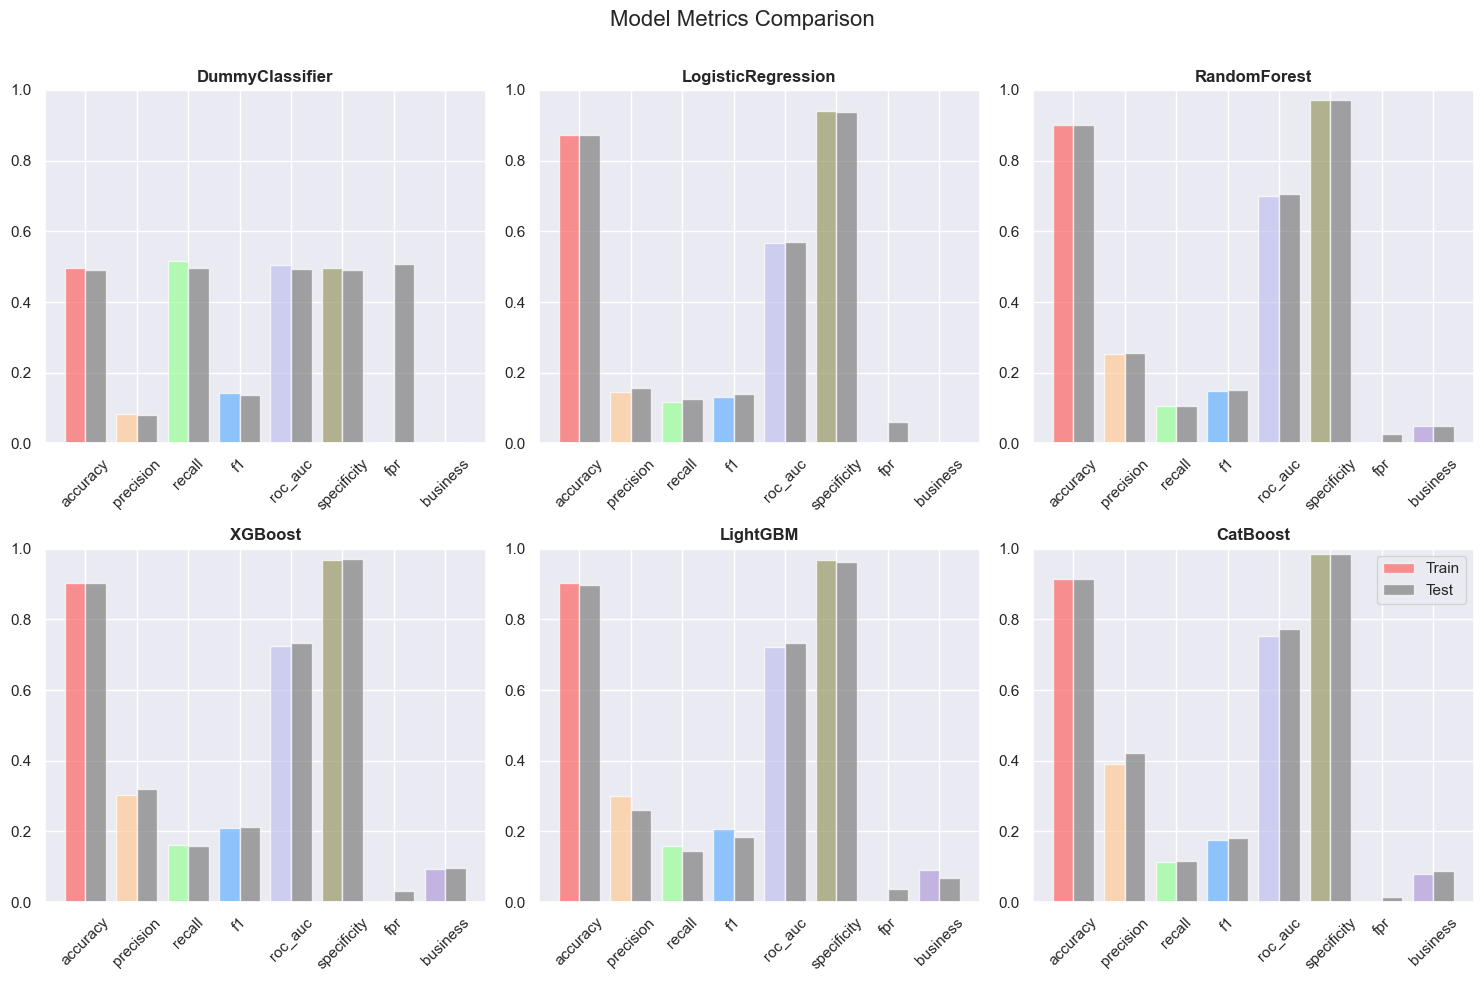

In [297]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'specificity', 'fpr', 'business']
plot_metrics(results_cv_tuned, results_test_tuned, metrics)

In [298]:
# Comparison between model before and after fine tuning

def plot_metrics_dual_per_model(model_name, train_results, test_results, train_results_ft, test_results_ft):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'specificity', 'fpr', 'business']
    
    # Define colors
    colors = {'Val': 'darkblue', 'Test': 'darkorange', 'Val-FT': 'darkblue', 'Test-FT': 'darkorange'}

    # Create a 2x4 grid of subplots
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.subplots_adjust(hspace=0.5, wspace=0.3)
    
    # Add a super title with the model's name
    fig.suptitle(model_name, fontsize=16)

    for i, metric in enumerate(metrics):
        ax = axes[i // 4, i % 4]
        data = [
            train_results.get(metric, 0),
            test_results.get(metric, 0),
            train_results_ft.get(metric, 0),
            test_results_ft.get(metric, 0),
        ]
        x_labels = ['Val', 'Test', 'Val-FT', 'Test-FT']

        ax.bar(x_labels, data, color=[colors[label] for label in x_labels])
        ax.set_ylabel(metric)
        ax.set_title(metric)

        # Rotate x-axis labels
        ax.set_xticklabels(x_labels, rotation=45)

        # Set y-axis limits to vary from 0 to 1
        ax.set_ylim(0, 1)

    plt.tight_layout()  # Set the layout tight
    plt.show()

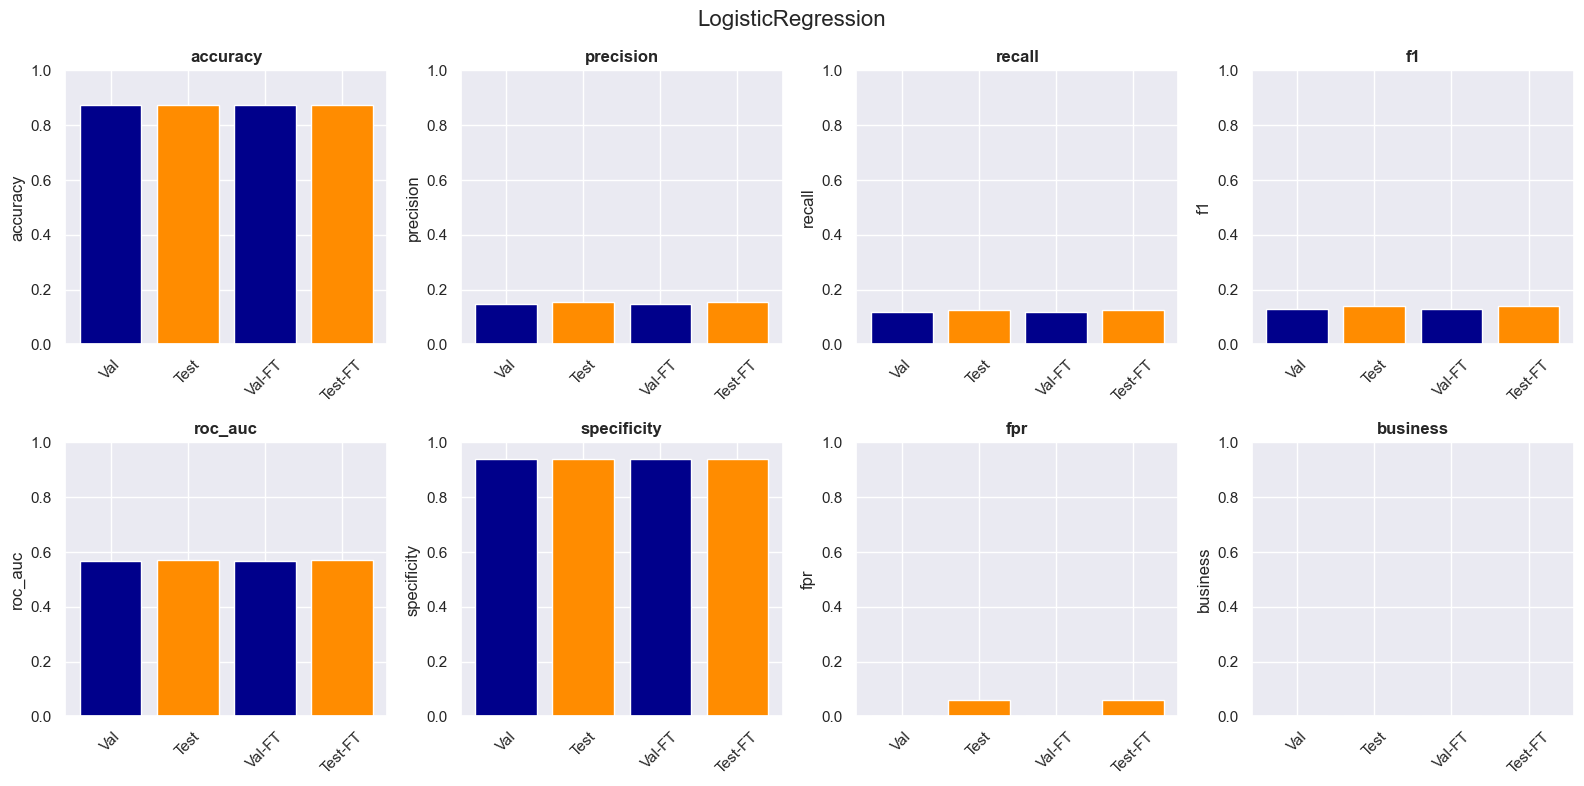

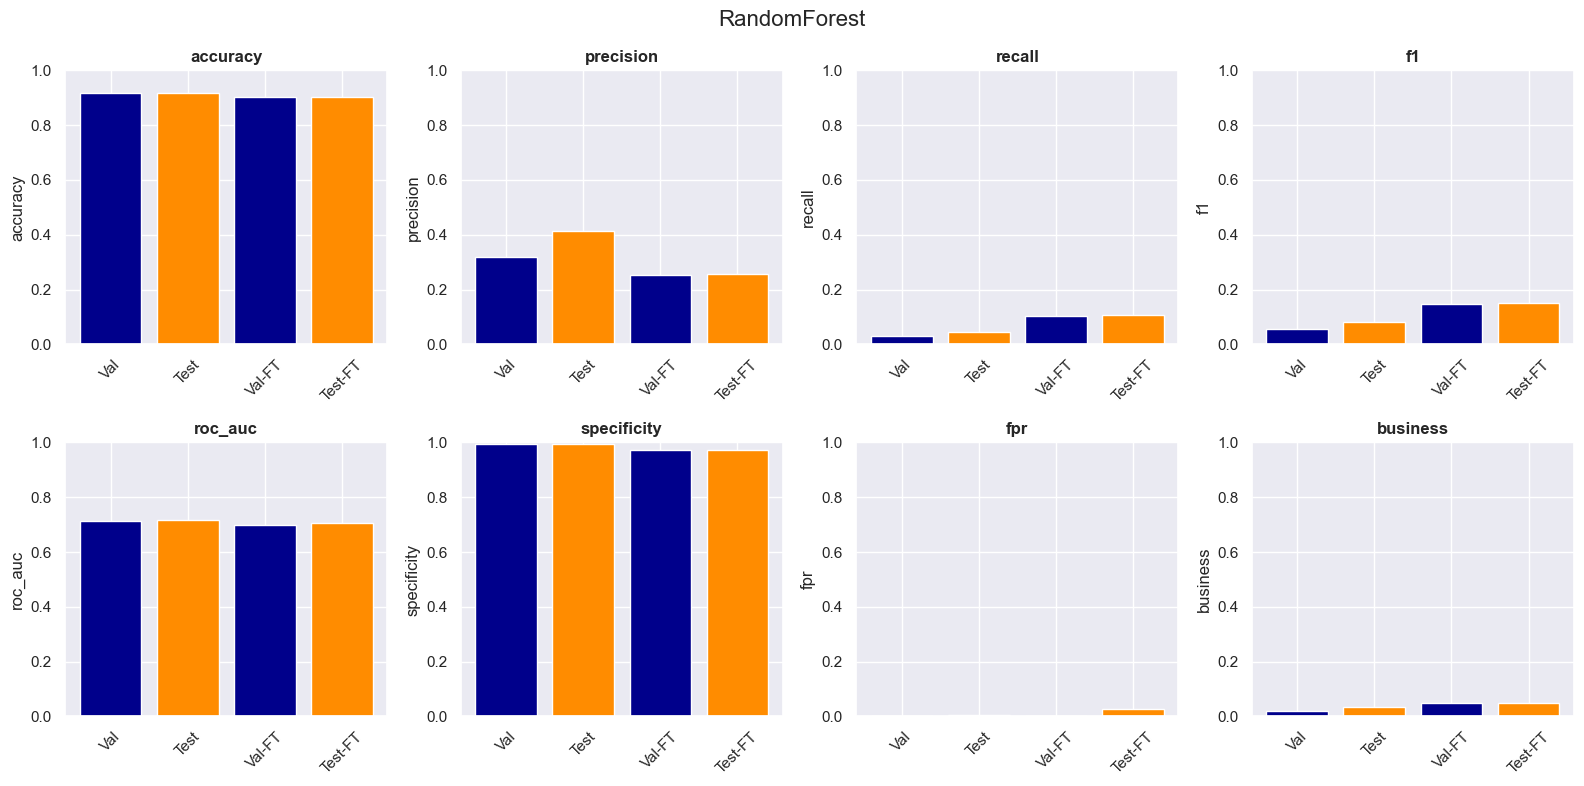

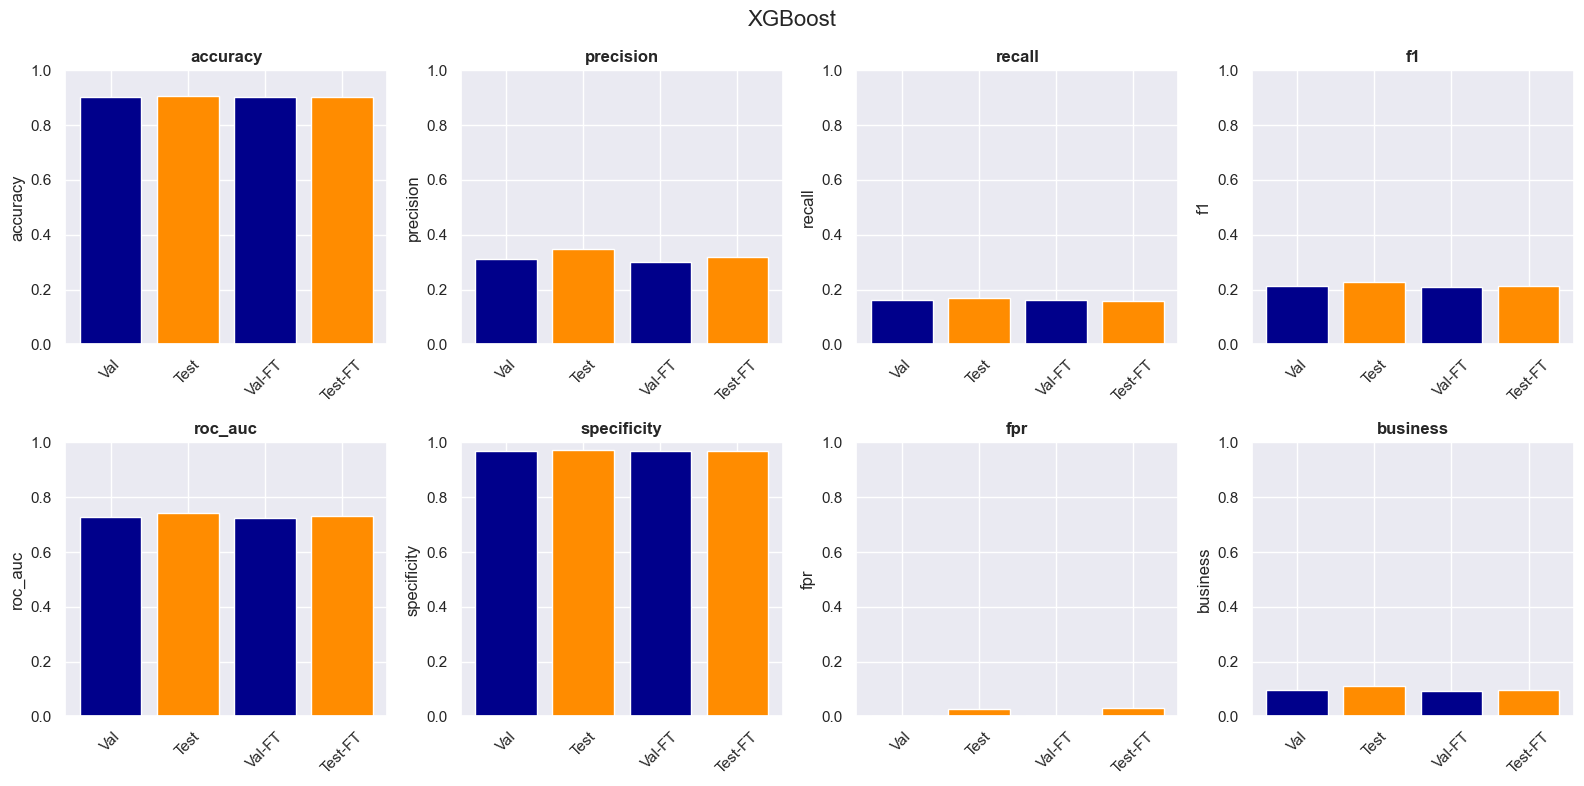

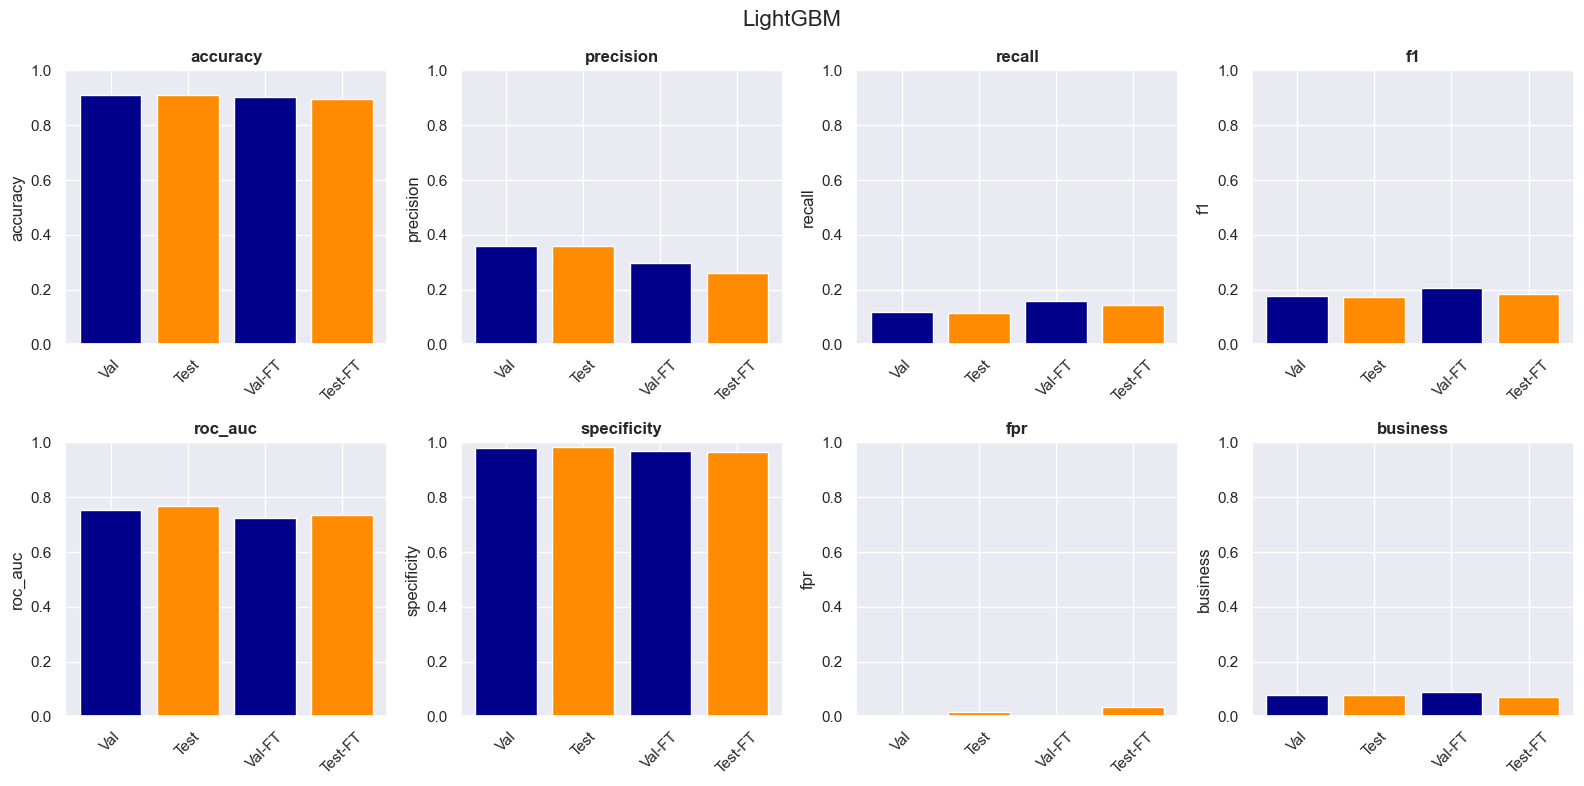

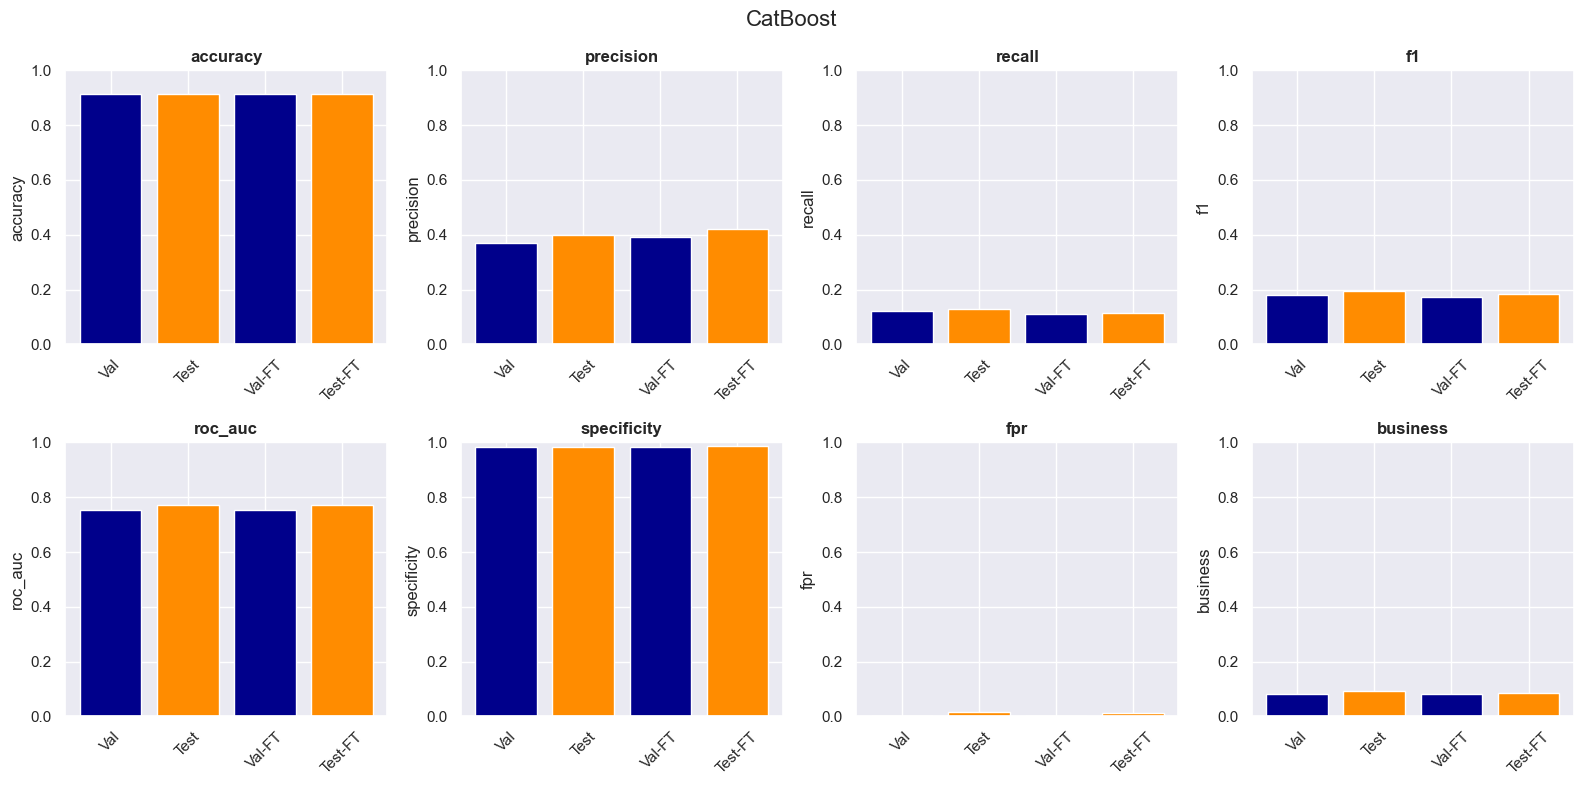

In [299]:
models = {'lr': 'LogisticRegression', 
          'rf': 'RandomForest', 
          'xgbc': 'XGBoost', 
          'lgbmc': 'LightGBM', 
          'cbc': 'CatBoost'}

for model, name in models.items():
    train_results = globals()[model + '_results_cv']
    test_results = globals()[model + '_results_test']
    train_results_ft = globals()[model + 't_results_cv']
    test_results_ft = globals()[model + 't_results_test']
    plot_metrics_dual_per_model(name, train_results, test_results, train_results_ft, test_results_ft)

XGBoost and LightGBM are the best models regarding Business score and Accuracy.
However, **LightGBM** was chosen because it takes a shorter time to train.

In [300]:
# Get best params of LigthGBM and fine tune around them + new hyper parameters

lgbmct_model.named_steps['classifier'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 200,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 0.9,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'device': 'cpu'}

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 14.1 µs
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 98619
[LightGBM] [Info] Number of data points in the train set: 28936, number of used features: 489
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98664
[LightGBM] [Info] Number of data points in the train set: 28936, number of used feat

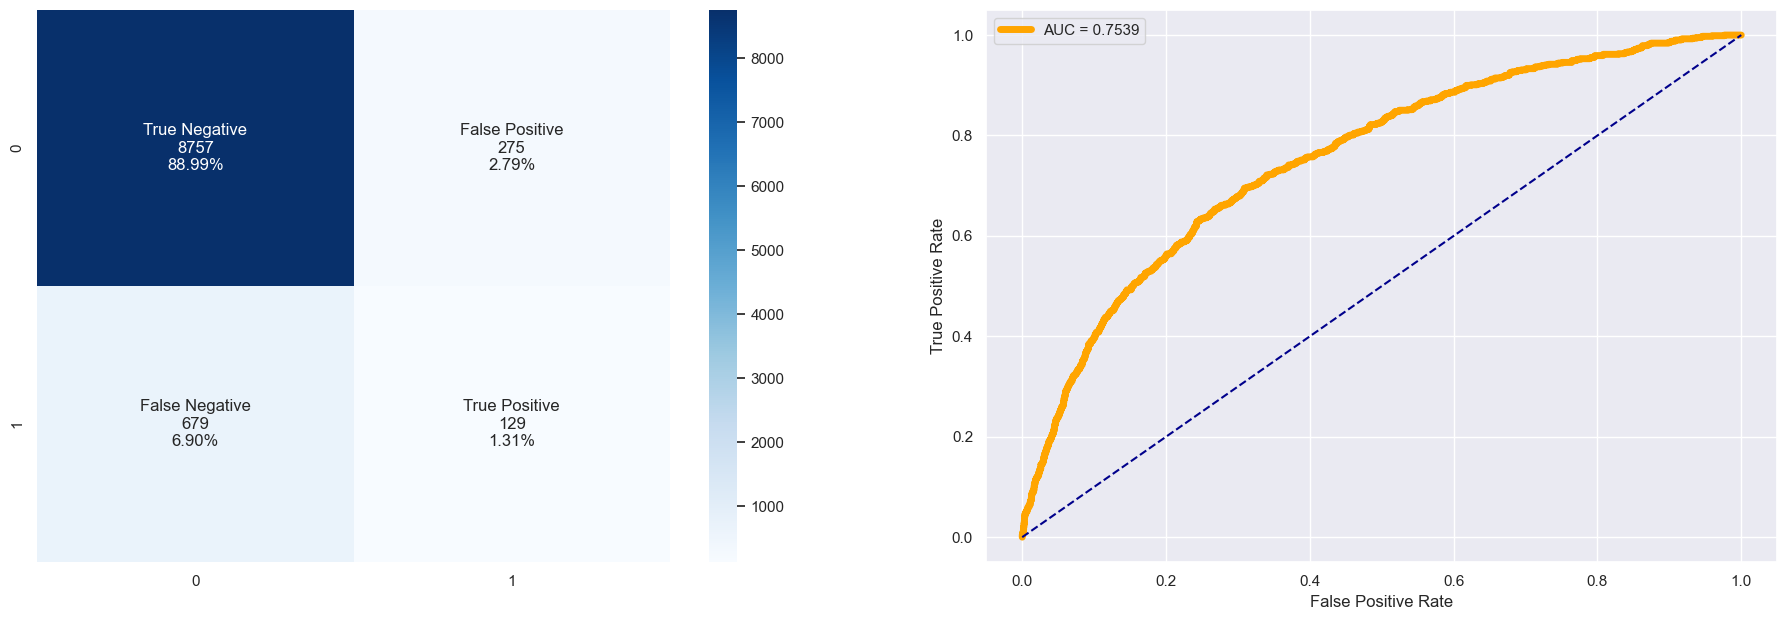

In [302]:
# Fine tune the best model around best params --> TO DO

%time
# Create LightGBM classifier
lgbmct = LGBMClassifier(random_state=RANDOM_STATE, device='cpu', n_jobs=-1)
lgbmct_name = 'LightGBM_fine_tuned_2'

# Set hyperparameter grid
param_grid = {
    'classifier__n_estimators': [x for x in range(100, 300, 10)],
    'classifier__max_depth': [3, 4, 5, 6, 7, 8, 9],
    'classifier__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0], 
    'classifier__num_leaves': [x for x in range(20, 50, 1)]
}

# Compute results and get fine-tuned model
lgbmct_model, lgbmct_results_cv, lgbmct_results_test = train_model_with_cross_val(lgbmct, param_grid=param_grid, cv=5, fast_train=0.2)

# Save logs
log_mlflow(lgbmct_model, lgbmct_name, params=lgbmct_model.named_steps['classifier'].get_params(), business_score=lgbmct_results_test['business'], 
           roc_auc=lgbmct_results_test['roc_auc'], f1_score=lgbmct_results_test['f1'], accuracy=lgbmct_results_test['accuracy'],
           precision=lgbmct_results_test['precision'], recall=lgbmct_results_test['recall'], specificity=lgbmct_results_test['specificity'],
           fpr=lgbmct_results_test['fpr'])




CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 13.1 µs
[LightGBM] [Info] Number of positive: 72364, number of negative: 72364
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.210152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 116640
[LightGBM] [Info] Number of data points in the train set: 144728, number of used features: 513
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

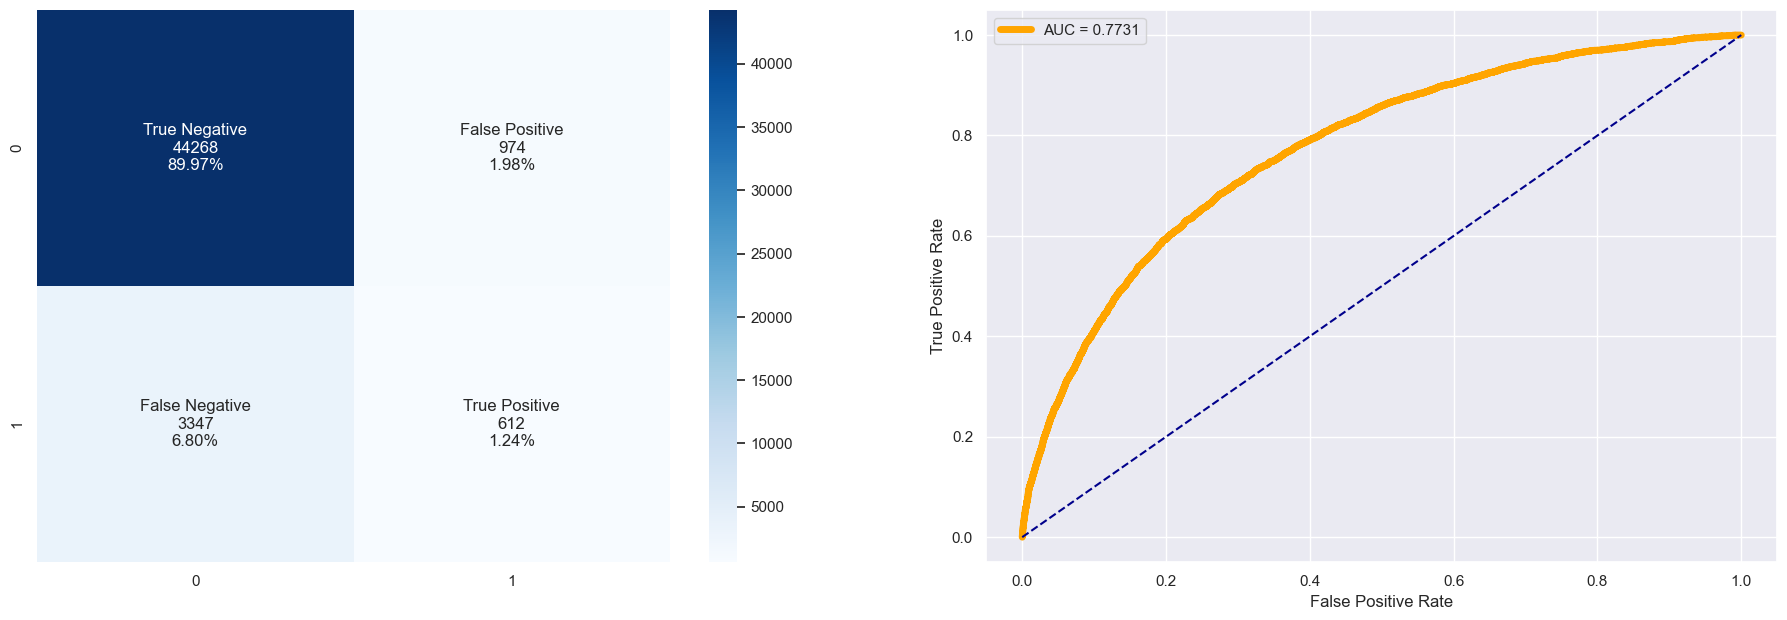

In [303]:
# Train the best model with the whole train dataset
%time
# Get the best params 
best_params = lgbmct_model.named_steps['classifier'].get_params()

# Create LightGBM classifier
lgbmc_final = LGBMClassifier(**best_params)
lgbmc_final_name = 'LightGBM_final'

# Compute results and get fine-tuned model
lgbmc_final_model, lgbmc_final_results_cv, lgbmc_final_results_test = train_model_with_cross_val(lgbmc_final)

# Save logs
log_mlflow(lgbmc_final_model, lgbmc_final_name, params=lgbmc_final_model.named_steps['classifier'].get_params(), business_score=lgbmc_final_results_test['business'], 
           roc_auc=lgbmc_final_results_test['roc_auc'], f1_score=lgbmc_final_results_test['f1'], accuracy=lgbmc_final_results_test['accuracy'],
           precision=lgbmc_final_results_test['precision'], recall=lgbmc_final_results_test['recall'], specificity=lgbmc_final_results_test['specificity'],
           fpr=lgbmc_final_results_test['fpr'])

#### Threshold selection

In [304]:
def threshold_selection(y_test, y_prob):
    thresholds = np.arange(0, 1, 0.001)
    scores = []
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype("int")
        score = business_loss_func(y_test, y_pred)
        scores.append(score)
        
    scores = np.asarray(scores)
    ix = np.argmax(scores)
    
    best_threshold, best_score = (thresholds[ix], round(scores[ix], 3))
    
    print("Best results")
    print("- Best Threshold:\t", best_threshold)
    print("- Best Score:\t\t", best_score)
    print("\n")
    
    plt.subplots(1, figsize=(6, 5))
    plt.plot(thresholds, scores, lw=1)
    plt.axvline(best_threshold, ls="--", lw=1, c="r")
    plt.title("Threshold")
    plt.xlabel("proba threshold")
    plt.ylabel("Score performed")
    plt.show()
    
    return best_threshold

In [305]:
# Function to compute roc curve
def compute_roc_curve(y_test, y_pred_proba, model_name="Model", disp_best_th=False):
    # Compute metrics
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Create fig
    plt.figure()
    plt.title(model_name + ": ROC curve")

    # Display x=y
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')

    # Display ROC curve
    sns.lineplot(x=fpr, y=tpr, legend='brief', label="AUC = {:.3f}".format((auc)))

    if disp_best_th is True:

        # Compute best threshold
        o_tpr = tpr[np.argmax(tpr - fpr)]
        o_fpr = fpr[np.argmax(tpr - fpr)]
        o_threshold = thresholds[np.argmax(tpr - fpr)]

        # Display best threshold
        sns.scatterplot(x=[o_fpr], y=[o_tpr], legend='brief', label="Best threshold = {:.3f}".format(o_threshold))

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

    # Return AUC score
    return auc

In [306]:
# Function to display confusion matrix
def display_confusion_matrix(y_test, y_pred, model_name="Model"):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(model_name + ": Confusion matrix")
    plt.grid(visible=None)
    plt.show()

In [307]:
# Get proba predictions from xgbc model to be class 1 : repay failure
lgbmc_proba = lgbmc_final_model.predict_proba(x_test)[:,1]

Best results
- Best Threshold:	 0.27
- Best Score:		 0.207




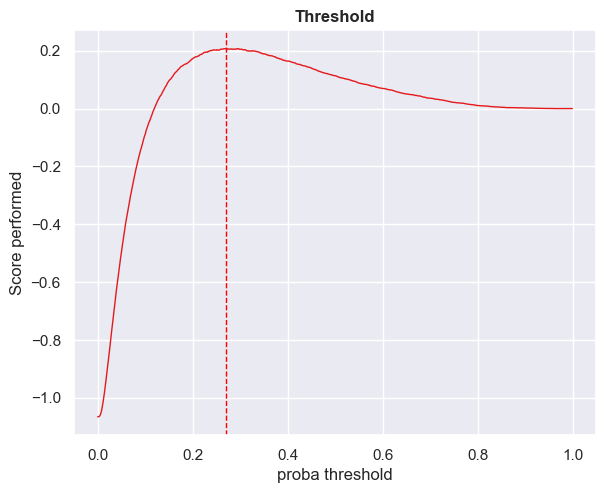

In [308]:
threshold = threshold_selection(y_test, lgbmc_proba)

The best prediction threshold is given by the point where the true positive rate and false positive rate are the lower. 
Here it gives us 0.27

Let's try different value of the prediction threshold : [0.5, 0.4, 0.3, 0.2, 0.1]

Printing results for threshold = 0.5
Business score = 0.11378711740520786


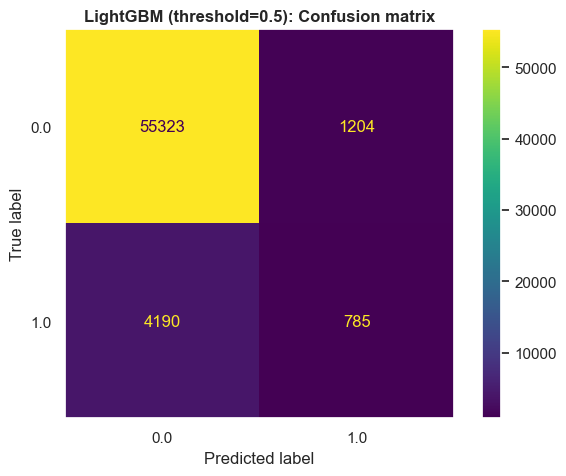

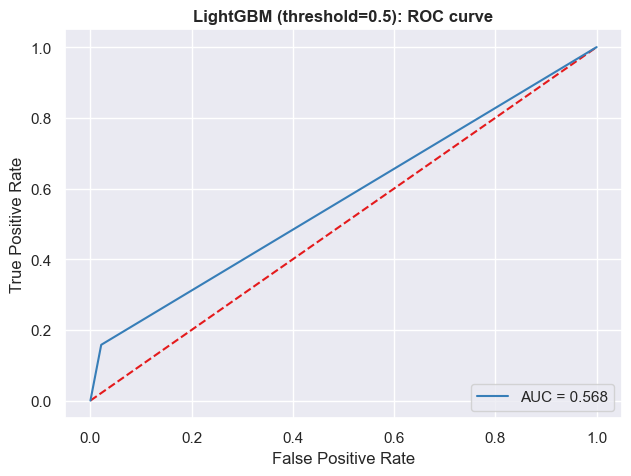

,precision,recall,f1-score,support
0.0,0.929595,0.978700,0.953516,56527.000000
1.0,0.394671,0.157789,0.225445,4975.000000
accuracy,0.912296,0.912296,0.912296,0.912296
macro avg,0.662133,0.568245,0.589481,61502.000000
weighted avg,0.886324,0.912296,0.894621,61502.000000


Printing results for threshold = 0.3
Business score = 0.20498857925993605


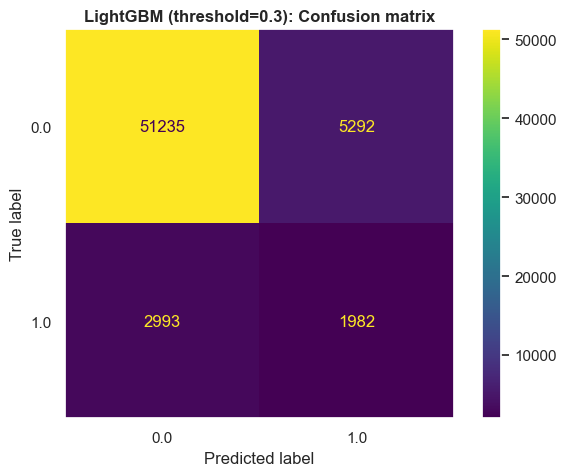

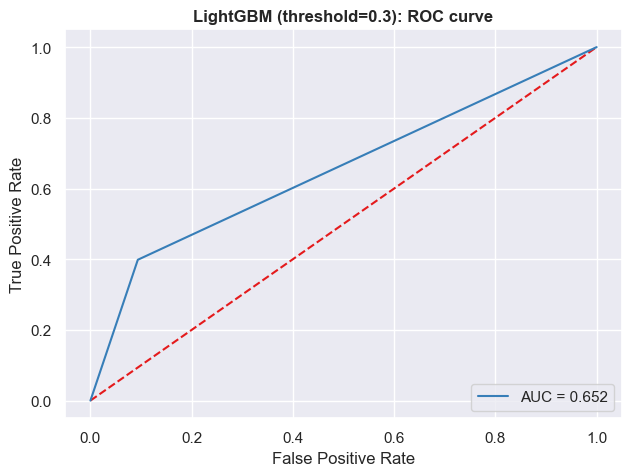

,precision,recall,f1-score,support
0.0,0.944807,0.906381,0.925195,56527.000000
1.0,0.272477,0.398392,0.323618,4975.000000
accuracy,0.865289,0.865289,0.865289,0.865289
macro avg,0.608642,0.652386,0.624407,61502.000000
weighted avg,0.890421,0.865289,0.876533,61502.000000


Printing results for threshold = 0.27
Business score = 0.20743718592964824


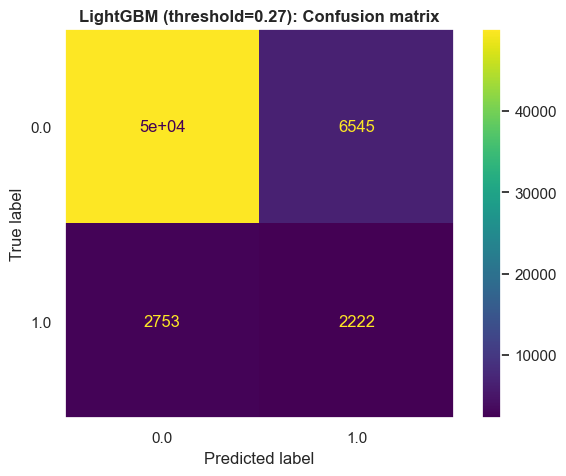

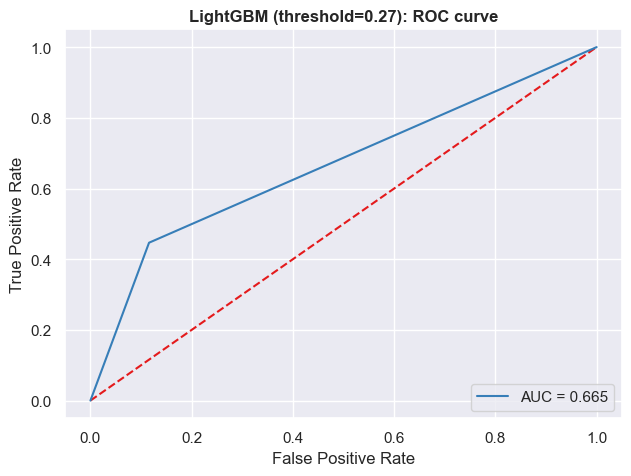

,precision,recall,f1-score,support
0.0,0.947796,0.884215,0.914902,56527.000000
1.0,0.253450,0.446633,0.323388,4975.000000
accuracy,0.848818,0.848818,0.848818,0.848818
macro avg,0.600623,0.665424,0.619145,61502.000000
weighted avg,0.891629,0.848818,0.867053,61502.000000


Printing results for threshold = 0.2
Business score = 0.17251713111009592


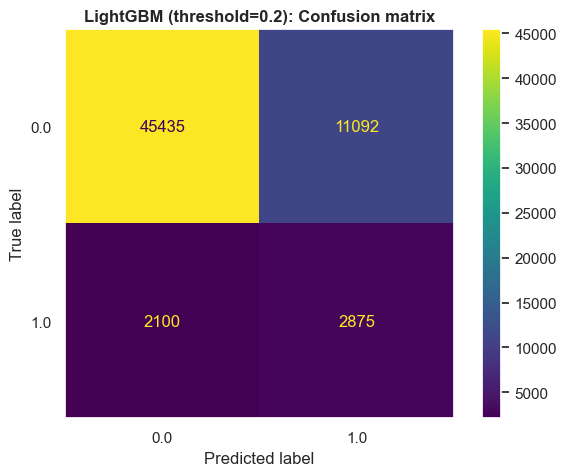

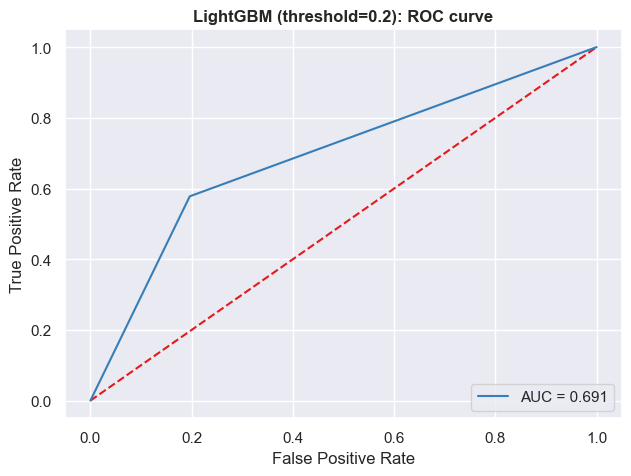

,precision,recall,f1-score,support
0.0,0.955822,0.803775,0.873229,56527.000000
1.0,0.205842,0.577889,0.303558,4975.000000
accuracy,0.785503,0.785503,0.785503,0.785503
macro avg,0.580832,0.690832,0.588394,61502.000000
weighted avg,0.895155,0.785503,0.827148,61502.000000


In [318]:
for threshold in [0.5, 0.3, 0.27, 0.2]: 
    print(f'Printing results for threshold = {threshold}')
    lgbm_pred_std = lgbmc_proba >= threshold
    business_score = business_loss_func(y_test, lgbm_pred_std)
    print('Business score =', business_score)
    display_confusion_matrix(y_test, lgbm_pred_std, model_name=f'LightGBM (threshold={str(threshold)})')
    auc_score = compute_roc_curve(y_test, lgbm_pred_std, model_name=f'LightGBM (threshold={str(threshold)})')
    clf_report = pd.DataFrame(classification_report(y_test, lgbm_pred_std, output_dict=True)).transpose()
    display(clf_report)


#### Explainer / Feature importance

##### Global feature importance

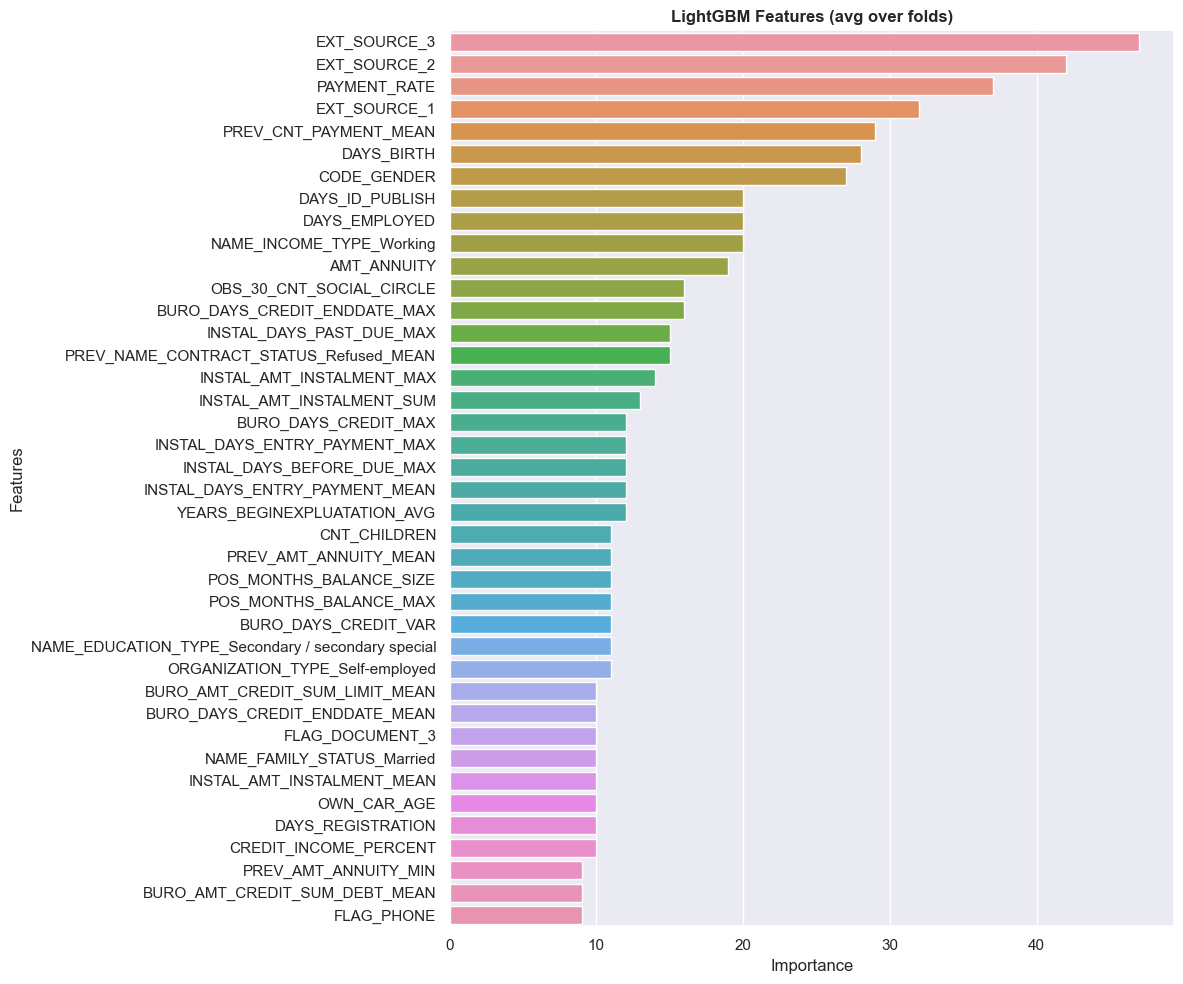

In [310]:
feature_importance_df_ = pd.DataFrame({'importance': lgbmc_final_model.steps[2][1].feature_importances_, 
                                       'feature': x_train.columns})

cols = feature_importance_df_[['feature', 'importance']].groupby('feature').mean().sort_values(by='importance', ascending=False)[:40].index
best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
plt.figure(figsize=(12, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("LightGBM Features (avg over folds)")
plt.tight_layout()
plt.show()

##### Local feature importance (SHAP)

In [311]:
shap_explainer = shap.TreeExplainer(lgbmc_final_model.steps[2][1])
shap_values = shap_explainer.shap_values(x_test)

In [312]:
idx = 1000

shap.force_plot(shap_explainer.expected_value[0], 
                shap_values[0][idx, :], 
                x_train.iloc[idx, :])


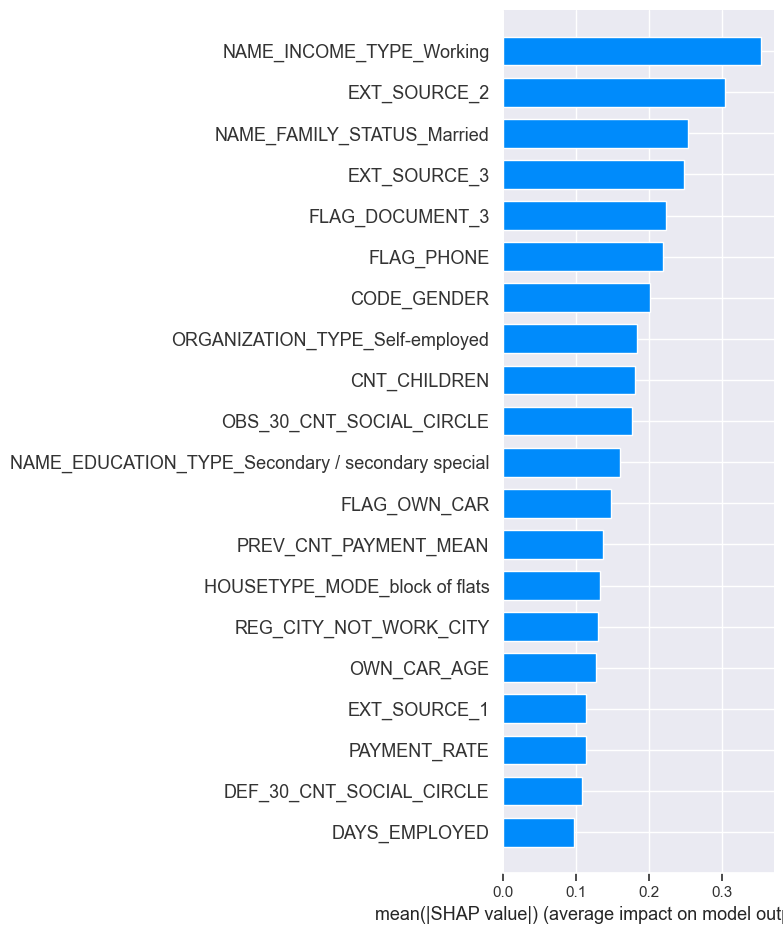

In [313]:
shap.summary_plot(shap_values[0], x_test, plot_type='bar')

#### Export

In [319]:
# Final model

filename = 'models/lightgbm_classifier.pkl'
pickle.dump(lgbmc_final_model, open(filename, 'wb'))

In [320]:
# SHAP explainer

filename = 'models/lightgbm_shap_explainer.pkl'
pickle.dump(shap_explainer, open(filename, 'wb'))